In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import numpy as np
import json
import math as m
from matplotlib import pyplot as plt
import statistics as s
from selenium import webdriver
import time
from IPython.display import clear_output
from collections import Counter
import seaborn as sns
from os import path
import missingno as msno
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Lasso
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import torch.optim as optim
import os

In [2]:
path = r'C:\studia\magisterka\pliki'

# Downloading data from the website

In [3]:
#link to iaaf website with all results under 10.55s from 6/04/1896 to 4/11/2022
url = 'https://www.worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?regionType=world&timing=electronic&windReading=regular&page=1&bestResultsOnly=true&firstDay=1896-04-06&lastDay=2022-11-04'

In [4]:
req = requests.get(url).content
soup = BeautifulSoup(req)

In [5]:
#number of pages with results
how_page = int(str(soup.find('div', class_ = 'container--pagination__inner').find_all('form')[0]).split('max="')[1].split('"')[0])

In [185]:
#creating a dictionary country abbreviation - country name
for i in range(len(soup.find_all('script'))):
    if 'requirejs' in str(soup.find_all('script')[i])[0:30]:
        dict_country = soup.find_all('script')[i]
dict_country = str(dict_country).split('toplists.init(')[1][25:].split(',\n')[0]
list_country = json.loads(dict_country)
list_country = list_country[5]['cases'][2]['values']
list_country[:5]

[{'value': 'afg', 'label': 'Afghanistan'},
 {'value': 'alb', 'label': 'Albania'},
 {'value': 'alg', 'label': 'Algeria'},
 {'value': 'asa', 'label': 'American Samoa'},
 {'value': 'and', 'label': 'Andorra'}]

In [190]:
#replacing the list with a dictionary in the form of abbreviation - name
#some countries no exist and abbreviations had to be added manually
dict_country_new = {}
for i in range(len(list_country)):
    dict_country_new[list_country[i]['value']] = list_country[i]['label']

dict_country_new['ana'] = 'Authorised Neutral Athlete'
dict_country_new['gdr'] = 'Nrd'
dict_country_new['urs'] = 'Ussr'
dict_country_new['frg'] = 'Rfn'
dict_country_new['aho'] = 'Netherlands Antilles'
dict_country_new['tch'] = 'Czechoslovakia'
dict_country_new['art'] = 'Athlete Refugee Team'
dict_country_new['yug'] = 'Yugoslavia'
dict_country_new['scg'] = 'Serbia and Montenegro'

In [12]:
np.save(path + '\dict_country_new.npy', dict_country_new) 

In [8]:
#downloading page sources for all subpages
soup_str = []
for i in range(how_page):
    url_str = 'https://www.worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?regionType=world&timing=electronic&windReading=regular&page=' + str(i+1) + '&bestResultsOnly=true&firstDay=1896-04-06&lastDay=2022-11-04'
    req_str = requests.get(url_str).content
    soup_str.append(BeautifulSoup(req_str))

In [9]:
#creating a dictionary with the name, country of birth, country abbreviation, player number, date of birth, 
    #link to the player's website
athelete = []
abb_coun = []
country = []
number = []
date = []
url_athelete = []
athelete_data = {}

for k in range(len(soup_str)):
    how_athlete = soup_str[k].find('table', class_ = 'records-table').find_all('tr')
    for i in range(1, len(how_athlete)):
        url_ath = 'https://www.worldathletics.org/athletes/'
        ath = how_athlete[i].find_all('a')[0].text.replace('  ', '').replace('\n','')
        athelete.append(ath)

        how_data = how_athlete[i].find_all('td')
        for j in range(len(how_data)):
            if str(how_data[j]).split('"')[1] == 'Nat':
                abb = how_data[j].text.replace(' ', '').replace('\n','').lower()
                abb_coun.append(abb)
                coun = dict_country_new[abb]
                country.append(coun)

            if str(how_data[j]).split('"')[1] == 'Competitor':
                num = str(how_data[j].find_all('a')[0]).split('"')[1].split('-')[-1].split('=')[-1] 
                number.append(num)                 # sometimes there is - before the number, and sometimes =

            if str(how_data[j]).split('"')[1] == 'DOB':
                if how_data[j].text == '\n':      #sometimes there is no date of birth
                    birth_date = np.nan
                else:
                    birth_date = how_data[j].text.replace('  ', '').replace('\n', '') 
                date.append(birth_date)
        url_a = url_ath + country[k*100+i-1].replace(' ', '') + '/' + number[k*100+i-1]
        url_athelete.append(url_a)
        athelete_data[k*100+i-1] = {'name': ath, 'country': coun, 'abb_coun': abb, 'number': num, 'birth_date': birth_date, 'url_athlete': url_a}

In [182]:
athelete_data[0]

{'name': 'Usain BOLT',
 'country': 'Jamaica',
 'abb_coun': 'jam',
 'number': '14201847',
 'birth_date': '21 AUG 1986',
 'url_athlete': 'https://www.worldathletics.org/athletes/Jamaica/14201847'}

In [11]:
df = pd.DataFrame(data = athelete_data).transpose()
df

,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,21 AUG 1986,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,09 AUG 1982,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,26 DEC 1989,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,23 NOV 1982,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,10 FEB 1982,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
9183,D. SUDHAKAR,India,ind,15022828,NaN,https://www.worldathletics.org/athletes/India/...
9184,Ahmed Hossam EL DIN ALI ABU ZAID,Egypt,egy,14956182,29 JUL 2002,https://www.worldathletics.org/athletes/Egypt/...
9185,Akito SUZUKI,Japan,jpn,14951335,07 AUG 2003,https://www.worldathletics.org/athletes/Japan/...
9186,Toshiaki ATOMI,Japan,jpn,014963765,12 JAN 1997,https://www.worldathletics.org/athletes/Japan/...


In [12]:
df.to_csv(path + '\df_first.csv')

In [13]:
#a function that changes the date in the form of a string to a date in the date type
def change_date(date_list):    #argument - list with dates, format: 18 NOV 1992
    day = []
    month = []
    year = []
    date = []
    months = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP':9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
    
    for i in range(len(date_list)):
        if date_list[i] == '' or (type(date_list[i]) == float and m.isnan(date_list[i])):    #if date is NaN
            date.append(np.nan)
            day.append(np.nan)
            month.append(np.nan)
            year.append(np.nan)

        else:
            if date_list[i].count(' ') == 2:                        #when correct date (day, month and year)
                day.append(date_list[i].split(' ')[0])
                month.append(months[date_list[i].split(' ')[1]])
                year.append(date_list[i].split(' ')[2])

            elif date_list[i].count(' ') == 1 and date_list[i][:-5] in months.keys() and date_list[i][-4:].isnumeric():
                day.append('1')                                      #only month and year
                month.append(months[date_list[i][:-5]])
                year.append(date_list[i][-4:])

            elif date_list[i].count(' ') == 0 and len(date_list[i]) == 4:
                day.append('1')                                     #only year
                month.append('1')
                year.append(date_list[i])

            elif len(date_list[i]) == 0:                            #no date
                day.append(np.nan)
                month.append(np.nan)
                year.append(np.nan)

            else:
                print(i, date_list[i])                               #unsupported cases

            if year[i] == np.nan:
                date.append(np.nan)

            else:
                d = day[i] + '-' + str(month[i]) + '-' + year[i]
                dd = datetime.strptime(d, '%d-%m-%Y').date()
                date.append(dd)
        
    return(date)

In [14]:
df['birth_date'] = change_date(df['birth_date'])
df

,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,1982-08-09,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,1989-12-26,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,1982-11-23,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,1982-02-10,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
9183,D. SUDHAKAR,India,ind,15022828,NaN,https://www.worldathletics.org/athletes/India/...
9184,Ahmed Hossam EL DIN ALI ABU ZAID,Egypt,egy,14956182,2002-07-29,https://www.worldathletics.org/athletes/Egypt/...
9185,Akito SUZUKI,Japan,jpn,14951335,2003-08-07,https://www.worldathletics.org/athletes/Japan/...
9186,Toshiaki ATOMI,Japan,jpn,014963765,1997-01-12,https://www.worldathletics.org/athletes/Japan/...


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9188 entries, 0 to 9187
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         9188 non-null   object
 1   country      9188 non-null   object
 2   abb_coun     9188 non-null   object
 3   number       9188 non-null   int64 
 4   birth_date   7949 non-null   object
 5   url_athlete  9188 non-null   object
dtypes: int64(1), object(5)
memory usage: 430.8+ KB


In [20]:
#save file
df.to_csv(path + '\df_iaaf_top_en.csv')

# Adding new athletes

In [22]:
#from another iaaf website you can download atheletes for a given year who have scores worse than 10.55
#until 2008 there are only scores below 10.55, so we download players from 2009

year_list =list(range(2009, 2022+1))
year_list

[2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

In [23]:
#for 1 year - 1 url
url_year = []
for i in range(len(year_list)):
    url_year.append('https://www.worldathletics.org/records/toplists/sprints/100-metres/outdoor/men/senior/' + str(year_list[i]) + '?regionType=world&timing=electronic&windReading=regular&page=1&bestResultsOnly=true')

In [24]:
#downloading page sources for website with results per year
soup_year = []
for i in range(len(url_year)):
    req = requests.get(url_year[i]).content
    soup_year.append(BeautifulSoup(req))

In [178]:
df_soup_year = pd.DataFrame(soup_year)
df_soup_year.to_csv(path + '\df_soup_year.csv')

In [27]:
#number of pages for each year
how_page_year = []
for i in range(len(soup_year)):
    how_page_year.append(int(str(soup_year[i].find('div', class_ = 'container--pagination__inner').find_all('form')[0]).split('max="')[1].split('"')[0]))
how_page_year            #every year more and more, only in 2020 less, due to the pandemic

[27, 39, 42, 48, 49, 53, 50, 50, 54, 58, 64, 35, 69, 80]

In [28]:
#all urls for 2009 - 2022
url = {}
for i in range(len(how_page_year)):
    list_url = []
    for j in range(how_page_year[i]):
        list_url.append('https://www.worldathletics.org/records/toplists/sprints/100-metres/outdoor/men/senior/' + str(year_list[i]) + '?regionType=world&timing=electronic&windReading=regular&page=' + str(j+1) + '&bestResultsOnly=true')
    url[year_list[i]] = list_url

In [31]:
#downloading page sources for each website with results per year 2009 - 2022
soup = {}
for j in (year_list):
        list_soup = []
        for i in range(len(url[j])):
            req = requests.get(url[j][i]).content
            list_soup.append(BeautifulSoup(req))
        soup[j] = list_soup

In [32]:
df_soup = pd.DataFrame([soup])
df_soup.to_csv(path + '\df_soup.csv')

In [33]:
#only pages with results worse than 10.55
page_limit = {}
for j in range(len(soup)):
    for i in range(len(soup[year_list[j]])):
        mark = float(soup[year_list[j]][i].find('table', class_ = 'records-table').find_all('tr')[1].find_all('td')[1].text.replace(' ', '').replace('\n',''))
        if mark > 10.55:
            page_limit[year_list[j]] = i-1
            break

In [176]:
#adding data to the dataframe for subsequent atheletes whose best result in the career is worse than 10.55
dicto = {}
for k in range(len(year_list)):
    for i in range(page_limit[year_list[k]], len(soup[year_list[k]])):
        ath = soup[year_list[k]][i].find('table', class_ = 'records-table').find_all('tr')
        for j in range(1, len(ath)): 
            if ath[j].find('a') is not None:   #some athletes are not numbered
                number = (int(str(ath[j].find('a')).replace('-', '=').split('">')[0].split('=')[-1]))
                if number not in df['number'].tolist():   #check if this player is already in df
                    new_number = number
                    name = (ath[j].find('a').text.replace('  ', '').replace('\n', ''))
                    abb_coun = str(ath[j].find('img', class_ = 'tableflag')).split('alt="')[1][:3]
                    date = ath[j].find_all('td')[4].text.replace('  ', '').replace('\n', '')
                    dicto = {'name': name, 'abb_coun': abb_coun, 'number': number, 'birth_date': date}
                    df = df.append(dicto, ignore_index=True)    #add to df

In [177]:
date = change_date(df['birth_date'][9188:].to_list())
df['birth_date'][9188:] = date

In [41]:
df

,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,1982-08-09,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,1989-12-26,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,1982-11-23,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,1982-02-10,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
33977,Katsuhiro AGA,NaN,JPN,15002600,2004-05-20,NaN
33978,Yuki NAKANO,NaN,JPN,15051808,2006-05-03,NaN
33979,Ravi RAI,NaN,IND,14873399,2004-08-07,NaN
33980,Rohan GHOSH,NaN,IND,15045591,2005-05-30,NaN


In [54]:
df.to_csv(path + '\df_with_new_athletes.csv')

In [42]:
#change type of date from str to datetime
df['birth_date'].replace('None', pd.NaT, inplace=True)

dd = []
for d in df['birth_date']:
    dd.append(pd.to_datetime(d))
df['birth_date'] = dd
df

,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,1982-08-09,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,1989-12-26,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,1982-11-23,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,1982-02-10,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
33977,Katsuhiro AGA,NaN,JPN,15002600,2004-05-20,NaN
33978,Yuki NAKANO,NaN,JPN,15051808,2006-05-03,NaN
33979,Ravi RAI,NaN,IND,14873399,2004-08-07,NaN
33980,Rohan GHOSH,NaN,IND,15045591,2005-05-30,NaN


In [43]:
#change upper case to lower in abb_coun column
df['abb_coun'] = df['abb_coun'].str.lower()

In [44]:
#function that uses a dictionary to change country abbreviations to a long country name
def change_country(abb_list):
    country_list = []
    for i in range(len(abb_list)):
        country_list.append(dict_country_new[abb_list[i]])
    return(country_list)

In [45]:
df['country'] = change_country(df['abb_coun'])
df

,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,1982-08-09,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,1989-12-26,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,1982-11-23,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,1982-02-10,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
33977,Katsuhiro AGA,Japan,jpn,15002600,2004-05-20,NaN
33978,Yuki NAKANO,Japan,jpn,15051808,2006-05-03,NaN
33979,Ravi RAI,India,ind,14873399,2004-08-07,NaN
33980,Rohan GHOSH,India,ind,15045591,2005-05-30,NaN


In [46]:
#creating url per athlete with name, country and number
def create_url(country_list, number_list):
    url_list = []
    url_new = 'https://www.worldathletics.org/athletes/'
    
    for i in range(len(country_list)):
        url_new = 'https://www.worldathletics.org/athletes/'
        url_new = url_new + country_list[i] + '/' + str(number_list[i])
        url_list.append(url_new)
    return(url_list)

In [407]:
df['url_athlete'][9188:] = create_url(df['country'][9188:].to_list(), df['number'][9188:].to_list())
df

,name,country,abb_coun,number,birth_date,url_athlete
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...
1,Tyson GAY,United States,usa,14238588,1982-08-09,https://www.worldathletics.org/athletes/United...
2,Yohan BLAKE,Jamaica,jam,14201842,1989-12-26,https://www.worldathletics.org/athletes/Jamaic...
3,Asafa POWELL,Jamaica,jam,14202176,1982-11-23,https://www.worldathletics.org/athletes/Jamaic...
4,Justin GATLIN,United States,usa,14238562,1982-02-10,https://www.worldathletics.org/athletes/United...
...,...,...,...,...,...,...
33977,Katsuhiro AGA,Japan,jpn,15002600,2004-05-20,https://www.worldathletics.org/athletes/Japan/...
33978,Yuki NAKANO,Japan,jpn,15051808,2006-05-03,https://www.worldathletics.org/athletes/Japan/...
33979,Ravi RAI,India,ind,14873399,2004-08-07,https://www.worldathletics.org/athletes/India/...
33980,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...


In [48]:
df.to_csv(path + '\df_all_athletes.csv')

# Athlete analysis

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33982 entries, 0 to 33981
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   name         33982 non-null  object        
 1   country      33982 non-null  object        
 2   abb_coun     33982 non-null  object        
 3   number       33982 non-null  int64         
 4   birth_date   23458 non-null  datetime64[ns]
 5   url_athlete  33982 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.6+ MB


### Birth date

In [50]:
min(df['birth_date'])

Timestamp('1932-02-08 00:00:00')

In [51]:
max(df['birth_date'])

Timestamp('2008-02-15 00:00:00')

In [52]:
#list comprehension - decades from date
year = [x.year for x in df['birth_date']]
dozen = [int(repr(x)[-2]) if type(x) == int else np.nan for x in year]
dozen2 = [(x * 10) + 2000 if x < 3 else (x*10)+1900 for x in dozen]

In [53]:
#most athletes were born in the 1990s
pd.Series(dozen2).value_counts()

1990.0    10343
2000.0     6247
1980.0     3931
1970.0     1468
1960.0      919
1950.0      431
1940.0      103
1930.0       16
dtype: int64

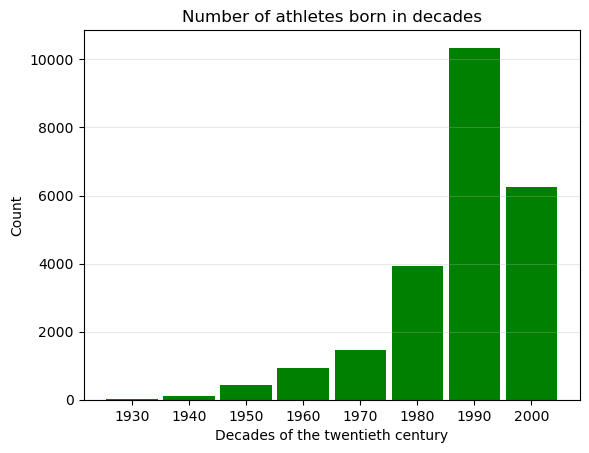

In [54]:
data = dict(pd.Series(dozen2).value_counts())
plt.bar(list(data.keys()), list(data.values()), color ='green', width = 9)

plt.grid(axis='y', alpha=0.3)
plt.xlabel("Decades of the twentieth century")
plt.ylabel("Count")
plt.title("Number of athletes born in decades")
plt.show()

### Country

In [55]:
df_country = df[['country', 'name']].groupby(by = 'country', as_index = False).count()
df_country = df_country.rename(columns = {'name': 'count'})
df_country = df_country.sort_values('count', ascending = False).reset_index().drop(columns = 'index')
df_country

,country,count
0,United States,13243
1,Japan,3432
2,Great Britain & N.I.,1103
3,France,963
4,Jamaica,904
...,...,...
199,Albania,1
200,Malawi,1
201,Solomon Islands,1
202,Monaco,1


Text(0, 0.5, 'Number of countries')

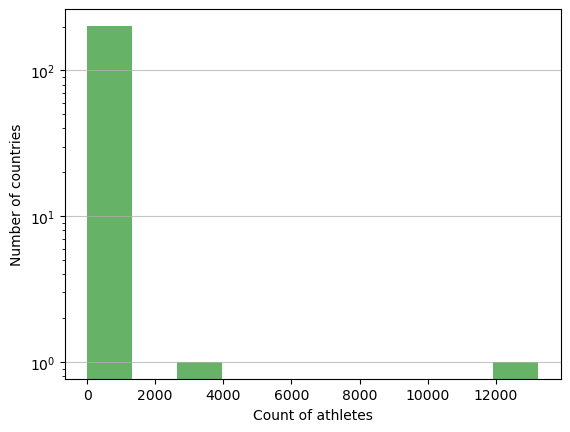

In [56]:
df_country['count'].plot(kind = 'hist', logy = True, color = 'green', alpha = 0.6)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Count of athletes')
plt.ylabel('Number of countries')

# Download results for athletes

### Active year per athlete

In [61]:
#downloading page sources for athletes
soup_ath = []
for i in range(len(df)):
    soup_ath.append(BeautifulSoup(requests.get(df['url_athlete'][i]).content))

In [62]:
#dictionary - number of athlete: list of active year
dict_year = {}
for i in range(len(soup_ath)):
    if len(str(BeautifulSoup(requests.get(df['url_athlete'][i]).content)).split('activeSeasons":')) <= 1:
        dict_year[df['number'][i]] = None
    else:
        dict_year[df['number'][i]] = json.loads(str(BeautifulSoup(requests.get(df['url_athlete'][i]).content)).split('activeSeasons":')[1].split(']')[0] + ']')

In [63]:
#new dictionary - double list 
dict_year2 = {}
for i in range(len(dict_year)):
    dict_year2[df['number'][i]] = ([(dict_year[df['number'][i]])])

In [64]:
#dictionary to DataFrame
df_years = pd.DataFrame(dict_year2)
df_years = df_years.T
df_years = df_years.rename(columns = {0: 'active_years'})

### Results per athlete

In [65]:
header={
"accept": "*/*",
"accept-encoding": "gzip, deflate, br",
"content-length": "934",
"content-type": "application/json",
"origin": "https://www.worldathletics.org",
"referer": "https://www.worldathletics.org",
"sec-ch-ua-mobile": "?0",
"sec-ch-ua-platform": "macOS",
"sec-fetch-dest": "empty",
"sec-fetch-mode": "cors",
"sec-fetch-site": "cross-site",
"user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36",
"x-amz-user-agent": "aws-amplify/3.0.2",
"x-api-key": "da2-ccv5yvixizdjdjtengkq2sbgsm"
}
url="https://2mlp5vgc7ffwlb763jx7yrizqu.appsync-api.eu-west-1.amazonaws.com/graphql"

In [66]:
def create_payload(y, idx):
    payload={
        "operationName":"GetSingleCompetitorResultsDiscipline",
        "variables":{
            "resultsByYear":y,
            "resultsByYearOrderBy":"discipline",
            "id":idx},
        "query":"query GetSingleCompetitorResultsDiscipline($id: Int, $resultsByYearOrderBy: String, $resultsByYear: Int) {\n  getSingleCompetitorResultsDiscipline(id: $id, resultsByYear: $resultsByYear, resultsByYearOrderBy: $resultsByYearOrderBy) {\n    parameters {\n      resultsByYear\n      resultsByYearOrderBy\n      __typename\n    }\n    activeYears\n    resultsByEvent {\n      indoor\n      disciplineCode\n      disciplineNameUrlSlug\n      typeNameUrlSlug\n      discipline\n      withWind\n      results {\n        date\n        competition\n        venue\n        country\n        category\n        race\n        place\n        mark\n        wind\n        notLegal\n        resultScore\n        remark\n        __typename\n      }\n      __typename\n    }\n    __typename\n  }\n}\n"}
    return payload

In [68]:
#downloading all results from the website
results = {}
for i in range(len(df_years)):
    lis = []
    for j in range(len(dict_year[list(dict_year.keys())[i]])):
        number = str(list(dict_year.keys())[i])              #athelete identification
        year = dict_year[list(dict_year.keys())[i]][j]       #results for the year
        pay = create_payload(year, number)
        resp = requests.post(url, headers=header, json=pay)
        
        competition = resp.json()['data']['getSingleCompetitorResultsDiscipline']['resultsByEvent']   
        
        for s in range(len(competition)):         #only 100m outdoor, not indoor
            if competition[s]['indoor'] == False and competition[s]['disciplineCode'] == '100':
                lis.append(resp.json()['data']['getSingleCompetitorResultsDiscipline']['resultsByEvent'][s]['results'])
    results[int(number)] = lis

In [70]:
#creating a list, and inside a dictionary with results, competitor number, date of competition, place of competition (city and country) and wind
competition_results = []
for k in range(len(df)):
    for i in range(len(results[df['number'][k]])):
        for j in range(len(results[df['number'][k]][i])):
            number = df['number'][k]
            result = results[df['number'][k]][i][j]['mark']
            date = results[df['number'][k]][i][j]['date']
            place = results[df['number'][k]][i][j]['venue']
            city = place.split(' (')[0].split(', ')[-1]
            country = place.split('(')[1][:3]
            wind = results[df['number'][k]][i][j]['wind']

            competition_results.append({'number': number, 'result':result, 'date_competition': date, 'country_competition': country, 'city_competition':city, 'wind':wind})

In [71]:
#convert list to DataFrame
df_results = pd.DataFrame(data = competition_results)

In [74]:
#change type of date from str to datetime
date = change_date(df_results['date_competition'])
df_results['date_competition'] = date

In [76]:
df_results

,number,result,date_competition,abb_country_competition,city_competition,wind
0,14164603,11.40,2009-07-23,SRB,Novi Sad,-2.3
1,14164603,11.09,2010-07-09,EST,Kose,+2.1
2,14164603,11.23,2010-07-16,EST,Tallinn,+2.4
3,14164603,11.21,2010-07-16,EST,Tallinn,-0.7
4,14164603,10.93,2011-06-04,FIN,Seinäjoki,+2.8
...,...,...,...,...,...,...
581272,15054047,10.88,2022-11-03,JPN,Omuta,+1.5
581273,15054107,10.71,2022-10-09,JPN,Yokohama,+1.8
581274,15054107,10.79,2022-10-09,JPN,Yokohama,+1.1
581275,15054126,10.96,2022-10-15,JPN,Kanazawa,+0.4


In [77]:
df_results.to_csv(path + '\df_result.csv')

In [78]:
#convert date to pandas datetime
df_results['date_competition'] = [pd.to_datetime(x) for x in df_results['date_competition']]

In [79]:
#change country abbreviations to a long country name
df_results['abb_country_competition'] = df_results['abb_country_competition'].str.lower()
df_results['country_competition'] = change_country(df_results['abb_country_competition'])

KeyError: 'fri'

In [175]:
#fix invalid records
df_results['abb_country_competition'][df_results['abb_country_competition'] == 'fri'] = 'usa'
df_results['city_competition'][df_results['city_competition'] == 'Adair Austin Stadium'] = 'KS'

In [81]:
#change country abbreviations to a long country name - with updated records
df_results['abb_country_competition'] = df_results['abb_country_competition'].str.lower()
df_results['country_competition'] = change_country(df_results['abb_country_competition'])

In [82]:
df_results

,number,result,date_competition,abb_country_competition,city_competition,wind,country_competition
0,14164603,11.40,2009-07-23,srb,Novi Sad,-2.3,Serbia
1,14164603,11.09,2010-07-09,est,Kose,+2.1,Estonia
2,14164603,11.23,2010-07-16,est,Tallinn,+2.4,Estonia
3,14164603,11.21,2010-07-16,est,Tallinn,-0.7,Estonia
4,14164603,10.93,2011-06-04,fin,Seinäjoki,+2.8,Finland
...,...,...,...,...,...,...,...
581272,15054047,10.88,2022-11-03,jpn,Omuta,+1.5,Japan
581273,15054107,10.71,2022-10-09,jpn,Yokohama,+1.8,Japan
581274,15054107,10.79,2022-10-09,jpn,Yokohama,+1.1,Japan
581275,15054126,10.96,2022-10-15,jpn,Kanazawa,+0.4,Japan


# Merge athlete to results

In [86]:
df_all = pd.merge(df, df_results, on = 'number')
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2007-07-18,gre,Rethymno,+0.7,Greece
1,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2008-03-08,jam,Spanish Town,+1.8,Jamaica
2,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.76,2008-05-03,jam,Kingston,+1.8,Jamaica
3,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.92,2008-05-17,tto,Port-of-Spain,+0.6,Trinidad and Tobago
4,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.72,2008-05-31,usa,NY,+1.7,United States
...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.22,2022-09-10,ind,Patna,NWI,India
581273,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,10.98,2022-09-10,ind,Patna,NWI,India
581274,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.12,2022-09-17,ind,Bhopal,-0.7,India
581275,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.00,2022-11-11,ind,Guwahati,0.0,India


### Age

In [87]:
#the age of the competitor at the time of the competition - age converted into years
age = [round((df_all['date_competition'][i] - df_all['birth_date'][i]).days/365, 2) for i in range(len(df_all))]
df_all['age'] = age
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2007-07-18,gre,Rethymno,+0.7,Greece,20.92
1,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2008-03-08,jam,Spanish Town,+1.8,Jamaica,21.56
2,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.76,2008-05-03,jam,Kingston,+1.8,Jamaica,21.72
3,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.92,2008-05-17,tto,Port-of-Spain,+0.6,Trinidad and Tobago,21.75
4,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.72,2008-05-31,usa,NY,+1.7,United States,21.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.22,2022-09-10,ind,Patna,NWI,India,17.29
581273,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,10.98,2022-09-10,ind,Patna,NWI,India,17.29
581274,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.12,2022-09-17,ind,Bhopal,-0.7,India,17.31
581275,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.00,2022-11-11,ind,Guwahati,0.0,India,17.46


### If country of birth and competition is the same

In [88]:
#comparison whether the competitor competed in the country of origin or not
if_country = [1 if df_all['abb_coun'][i] == df_all['abb_country_competition'][i] else 0 for i in range(len(df_all))]
df_all['if_country'] = if_country
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2007-07-18,gre,Rethymno,+0.7,Greece,20.92,0
1,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2008-03-08,jam,Spanish Town,+1.8,Jamaica,21.56,1
2,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.76,2008-05-03,jam,Kingston,+1.8,Jamaica,21.72,1
3,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.92,2008-05-17,tto,Port-of-Spain,+0.6,Trinidad and Tobago,21.75,0
4,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.72,2008-05-31,usa,NY,+1.7,United States,21.79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.22,2022-09-10,ind,Patna,NWI,India,17.29,1
581273,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,10.98,2022-09-10,ind,Patna,NWI,India,17.29,1
581274,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.12,2022-09-17,ind,Bhopal,-0.7,India,17.31,1
581275,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.00,2022-11-11,ind,Guwahati,0.0,India,17.46,1


In [89]:
df_all.to_csv(path + '\df_all.csv')

### Year of competition

In [90]:
year = [y.year for y in df_all['date_competition']]
df_all['year'] = year
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2007-07-18,gre,Rethymno,+0.7,Greece,20.92,0,2007
1,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2008-03-08,jam,Spanish Town,+1.8,Jamaica,21.56,1,2008
2,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.76,2008-05-03,jam,Kingston,+1.8,Jamaica,21.72,1,2008
3,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.92,2008-05-17,tto,Port-of-Spain,+0.6,Trinidad and Tobago,21.75,0,2008
4,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.72,2008-05-31,usa,NY,+1.7,United States,21.79,0,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.22,2022-09-10,ind,Patna,NWI,India,17.29,1,2022
581273,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,10.98,2022-09-10,ind,Patna,NWI,India,17.29,1,2022
581274,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.12,2022-09-17,ind,Bhopal,-0.7,India,17.31,1,2022
581275,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.00,2022-11-11,ind,Guwahati,0.0,India,17.46,1,2022


In [91]:
month = [y.month for y in df_all['date_competition']]
df_all['month'] = month
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year,month
0,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2007-07-18,gre,Rethymno,+0.7,Greece,20.92,0,2007,7
1,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,10.03,2008-03-08,jam,Spanish Town,+1.8,Jamaica,21.56,1,2008,3
2,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.76,2008-05-03,jam,Kingston,+1.8,Jamaica,21.72,1,2008,5
3,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.92,2008-05-17,tto,Port-of-Spain,+0.6,Trinidad and Tobago,21.75,0,2008,5
4,Usain BOLT,Jamaica,jam,14201847,1986-08-21,https://www.worldathletics.org/athletes/Jamaic...,9.72,2008-05-31,usa,NY,+1.7,United States,21.79,0,2008,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.22,2022-09-10,ind,Patna,NWI,India,17.29,1,2022,9
581273,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,10.98,2022-09-10,ind,Patna,NWI,India,17.29,1,2022,9
581274,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.12,2022-09-17,ind,Bhopal,-0.7,India,17.31,1,2022,9
581275,Rohan GHOSH,India,ind,15045591,2005-05-30,https://www.worldathletics.org/athletes/India/...,11.00,2022-11-11,ind,Guwahati,0.0,India,17.46,1,2022,11


## Preparations before calculating the start number

In [92]:
#sort needed for grouping
df_all = df_all.sort_values(['number', 'date_competition']).reset_index().drop(columns = 'index')
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year,month
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,-2.3,Serbia,19.55,0,2009,7
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,+2.1,Estonia,20.51,1,2010,7
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,+2.4,Estonia,20.53,1,2010,7
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,-0.7,Estonia,20.53,1,2010,7
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,+2.8,Finland,21.42,0,2011,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,+1.5,Japan,17.09,1,2022,11
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,+1.8,Japan,17.30,1,2022,10
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,+1.1,Japan,17.30,1,2022,10
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,+0.4,Japan,18.64,1,2022,10


In [93]:
def start_number(columns, how_start):
    how_per = list(df_all.groupby(columns).size().reset_index(name = how_start)[how_start])
    
    start = []
    for how in how_per:
        for j in range(how):
            start.append(j+1)
    return start

### Career start number

In [94]:
start_career = start_number(['number'], 'career')
df_all['start_career'] = start_career

### Season start number

In [95]:
start_season = start_number(['number', 'year'], 'season')
df_all['start_season'] = start_season

In [96]:
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year,month,start_career,start_season
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,-2.3,Serbia,19.55,0,2009,7,1,1
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,+2.1,Estonia,20.51,1,2010,7,2,1
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,+2.4,Estonia,20.53,1,2010,7,3,2
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,-0.7,Estonia,20.53,1,2010,7,4,3
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,+2.8,Finland,21.42,0,2011,6,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,+1.5,Japan,17.09,1,2022,11,1,1
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,+1.8,Japan,17.30,1,2022,10,1,1
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,+1.1,Japan,17.30,1,2022,10,2,2
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,+0.4,Japan,18.64,1,2022,10,1,1


### Wind

convert str to float

In [97]:
#checking if all values are numeric
df_all['wind'].unique()

array(['-2.3', '+2.1', '+2.4', '-0.7', '+2.8', '+1.2', '-1.2', '+0.2',
       '-0.9', '+0.9', '+3.8', '+3.2', '+3.1', '-0.2', '+1.5', '-1.8',
       '-2.5', '-1.5', '+1.1', '-1.7', '0.0', '+2.2', '+3.4', '+1.0',
       '+1.6', '+1.4', '+0.4', '+1.9', '+1.3', '+2.7', '+2.6', '+0.3',
       '+0.6', '-0.4', '+0.7', '-0.5', '+1.7', '+2.0', '-1.3', '+0.8',
       nan, '+3.5', '-0.6', '+1.8', '-1.6', '+0.1', '-1.9', '-0.3',
       '+2.5', '+0.5', '-2.8', '-1.4', '-1.0', '-4.6', '-0.1', '+2.3',
       '-3.7', '+5.0', '-2.0', '+4.9', '+4.2', '+3.6', '-2.9', '-1.1',
       '-0.8', '-3.3', '+4.4', '+3.0', '+3.3', 'NWI', '+5.2', '-2.1',
       '+7.3', '+7.0', '+2.9', '+3.7', '-2.6', '-5.3', '-2.7', '-3.1',
       '+4.5', '-3.4', '+3.9', '+4.0', 'w', '+4.1', '-2.4', '+5.4',
       '-3.0', '-3.6', '-2.2', '+4.8', '+4.3', '-8.6', '+4.6', '+5.1',
       '+6.0', '+6.6', '-4.2', '-4.8', '+5.9', '+7.5', '+6.1', '-3.8',
       '-3.9', '+5.8', '-3.5', '+5.5', '-3.2', '+4.7', '-4.4', '-4.7',
       '+5.3',

In [98]:
#there are 'NWI' and 'w' values that need to be converted to nan
df_all['wind'] = df_all.apply(lambda row: np.nan if row['wind'] == 'NWI' or row['wind'] == 'w' else row['wind'], axis=1)

In [99]:
df_all['wind'] = df_all['wind'].astype(float)

### current PB/ SB - wind included

PB - personal best, SB - season best

personal/seasonal bests in sprints are recognized if the wind blows at a maximum of 2 m/s

In [100]:
def actual_record(col_start, col_wind, col_result):
    rec_list = []
    s = 0
    for w in range(len(col_start)):
        if col_start[w] == 1:
            rec_list.append([np.nan])
            s = s + 1
            if type(rec_list[s-1][-1]) != float:
                print(s, rec_list[s-1][-1])

        elif col_start[w] > 1 and (col_wind[w-1] > 2 or m.isnan(col_wind[w-1])) and m.isnan(rec_list[s-1][-1]):
            rec_list.append([np.nan])
            s = s+1

        elif s > 0 and (col_wind[w-1] > 2 or m.isnan(col_wind[w-1])) and m.isnan(rec_list[s-1][-1]) is False:
            rec_list[s-1].append(rec_list[s-1][-1])

        else:
            rec_list[s-1].append(col_result[w-1])
            
    rec_list2 = []
    for t in range(len(rec_list)):
        rec_list2.append(rec_list[t][0])
        if len(rec_list[t]) == 2:
            rec_list2.append(rec_list[t][1])
        elif len(rec_list[t]) > 2:
            rec_list2.append(rec_list[t][1])
            mini = rec_list[t][1]
            for j in range(2, len(rec_list[t])):
                if rec_list[t][j] < mini:
                    mini = rec_list[t][j]
                rec_list2.append(mini)
    return(rec_list2)

In [101]:
pb_record = actual_record(df_all['start_career'], df_all['wind'], df_all['result'])

In [102]:
sb_record = actual_record(df_all['start_season'], df_all['wind'], df_all['result'])

In [103]:
df_all['pb'] = pb_record
df_all['sb'] = sb_record

In [104]:
df_all

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,wind,country_competition,age,if_country,year,month,start_career,start_season,pb,sb
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,-2.3,Serbia,19.55,0,2009,7,1,1,NaN,NaN
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,2.1,Estonia,20.51,1,2010,7,2,1,11.40,NaN
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,2.4,Estonia,20.53,1,2010,7,3,2,11.40,NaN
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,-0.7,Estonia,20.53,1,2010,7,4,3,11.40,NaN
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,2.8,Finland,21.42,0,2011,6,5,1,11.21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,1.5,Japan,17.09,1,2022,11,1,1,NaN,NaN
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,1.8,Japan,17.30,1,2022,10,1,1,NaN,NaN
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,1.1,Japan,17.30,1,2022,10,2,2,10.71,10.71
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,0.4,Japan,18.64,1,2022,10,1,1,NaN,NaN


In [105]:
df_all.to_csv(path + '\df_all_pb_sb.csv')

### Height above sea level

The height at which the runners run affects their well-being as well as the results, a csv file was found that shows the average height above sea level for countries.

In [106]:
df_height = pd.read_csv(path + '\country_height.csv', sep = ';')   
df_height

,country,height
0,Afghanistan,"1,884 m (6,181 ft)"
1,Albania,"708 m (2,323 ft)"
2,Algeria,"800 m (2,625 ft)"
3,Andorra,"1,996 m (6,549 ft)"
4,Angola,"1,112 m (3,648 ft)"
...,...,...
167,Vietnam,"398 m (1,306 ft)"
168,Western Sahara,256 m (840 ft)
169,Yemen,"999 m (3,278 ft)"
170,Zambia,"1,138 m (3,734 ft)"


In [107]:
#convert height from str to float
def fun_height(t):
    if 'm' in t:
        t = t.split('m')[0]
    if ',' in t:
        t = t.replace(',','')
    t = int(float(t))
    return t

df_height['height'] = df_height['height'].apply(fun_height)
df_height = df_height.rename(columns = {'country': 'country_competition'})
df_height

,country_competition,height
0,Afghanistan,1884
1,Albania,708
2,Algeria,800
3,Andorra,1996
4,Angola,1112
...,...,...
167,Vietnam,398
168,Western Sahara,256
169,Yemen,999
170,Zambia,1138


In [108]:
#merge DataFrames: df_height and df_all
df_all2 = pd.merge(df_all, df_height, how="left", on=["country_competition"])
df_all2

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,country_competition,age,if_country,year,month,start_career,start_season,pb,sb,height
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,...,Serbia,19.55,0,2009,7,1,1,NaN,NaN,473.0
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,...,Estonia,20.51,1,2010,7,2,1,11.40,NaN,61.0
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,...,Estonia,20.53,1,2010,7,3,2,11.40,NaN,61.0
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,...,Estonia,20.53,1,2010,7,4,3,11.40,NaN,61.0
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,...,Finland,21.42,0,2011,6,5,1,11.21,NaN,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,...,Japan,17.09,1,2022,11,1,1,NaN,NaN,438.0
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,...,Japan,17.30,1,2022,10,1,1,NaN,NaN,438.0
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,...,Japan,17.30,1,2022,10,2,2,10.71,10.71,438.0
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,...,Japan,18.64,1,2022,10,1,1,NaN,NaN,438.0


In [109]:
#list of countries for which the height has not been assigned
country_without_height = set(df_all2['country_competition'][df_all2['height'].isna()])
print(country_without_height, len(country_without_height))

{'Netherlands Antilles', 'Chinese Taipei', 'Slovak Republic', 'Côte d’Ivoire', 'American Samoa', 'Samoa', 'Guam', 'Norfolk Island', 'Puerto Rico', 'Bahamas', 'Turks and Caicos Islands', 'Barbados', 'Islamic Republic of Iran', 'Ussr', 'Nrd', 'Yugoslavia', 'Hong Kong, China', 'Tonga', 'Czechoslovakia', 'Aruba', 'Macao, China', 'Cayman Islands', 'Saint Vincent', 'Congo', 'French Polynesia', 'Republic of North Macedonia', 'Saint Kitts and Nevis', 'Gibraltar', 'Bahrain', 'Saint Lucia', 'Mauritius', 'Surinam', 'Great Britain & N.I.', 'Democratic Republic of Congo', 'Monaco', 'Türkiye', 'Micronesia', 'Korea', 'Northern Mariana Islands', 'DPR of Korea', 'Cook Islands', 'Fiji', 'Malta', 'Grenada', 'Bosnia-Herzegovina', 'San Marino', 'British Virgin Islands', 'Liechtenstein', 'PR of China', 'Rfn', 'Bermuda'} 51


In [110]:
#some countries had different names in the two DataFrame so in df_height the names were changed
df_height = df_height.replace('Bosnia and Herzegovina', 'Bosnia-Herzegovina')
df_height = df_height.replace('Taiwan', 'Chinese Taipei')
df_height = df_height.replace('Republic of the Congo', 'Congo')
df_height = df_height.replace('Ivory Coast', 'Côte d’Ivoire')
df_height = df_height.replace('North Korea', 'DPR of Korea')
df_height = df_height.replace('Democratic Republic of the Congo', 'Democratic Republic of Congo')
df_height = df_height.replace('United Kingdom', 'Great Britain & N.I.')
df_height = df_height.replace('Iran', 'Islamic Republic of Iran')
df_height = df_height.replace('Kirghizistan', 'Kyrgyzstan')
df_height = df_height.replace('South Korea', 'Korea')
df_height = df_height.replace('China', 'PR of China')
df_height = df_height.replace('North Macedonia', 'Republic of North Macedonia')
df_height = df_height.replace('Slovakia', 'Slovak Republic')
df_height = df_height.replace('Suriname', 'Surinam')
df_height = df_height.replace('Gambia', 'The Gambia')
df_height = df_height.replace('Turkey', 'Türkiye')

In [111]:
#for some countries an average height was found or calculated as an average: Czechoslovakia = (Czech Republic + Slovakia)/2
countries = ['Anguilla', 'Antigua & Barbuda', 'Bahamas', 'Bahrain', 'Barbados', 'Bermuda', 'Commonwealth of Dominica', 'Comoros', 'Czechoslovakia', 'Fiji', 'French Polynesia', 'Grenada', 'Hong Kong, China', 'Macao, China', 'Malta', 'Mauritius', 'Micronesia', 'Monaco', 'Netherlands Antilles', 'Nrd', 'Palau', 'Puerto Rico', 'Rfn', 'Saint Kitts and Nevis', 'San Marino', 'Sao Tome & Principe', 'Serbia and Montenegro', 'Seychelles', 'Solomon Islands', 'Tonga', 'Liechtenstein', 'Norfolk Island']
height = [33, 202, 32, 61, 180, 45, 850, 29, 444, 662, 1121, 420, 479, 114, 127, 1100, 2, 81, 30, 263, 121, 261, 263, 578, 749, 2024, 780, 453, 1166, 517, 453, 213]

In [174]:
for i in range(len(countries)):
    counry_height = {'country_competition': countries[i], 'height': height[i]}
    df_height = df_height.append(counry_height, ignore_index=True)

In [113]:
#reconnecting after repair and adding height for countries
df_all2 = pd.merge(df_all, df_height, how="left", on=["country_competition"])

In [115]:
#only 14 countries without height
country_without_height = set(df_all2['country_competition'][df_all2['height'].isna()])
print(country_without_height, len(country_without_height))

{'Turks and Caicos Islands', 'Yugoslavia', 'Ussr', 'Gibraltar', 'Saint Vincent', 'Saint Lucia', 'Aruba', 'British Virgin Islands', 'Northern Mariana Islands', 'Cayman Islands', 'Cook Islands', 'American Samoa', 'Samoa', 'Guam'} 14


In [116]:
df_all2.to_csv(path + '\df_all_height.csv')
df_height.to_csv(path + '\df_height_new.csv')

## Weather

### Weather conditions from the Weather Underground website

In [117]:
#to be able to concat city names with a date, you need to convert the date to a str type
date_str = [str(x).split(' ')[0] for x in df_all2['date_competition']]

In [118]:
#We perform the concatenation of the date and city, additionally the abbreviation of the country 
#because cities with the same names can occur in different countries.
placedate = list(set(df_all2['city_competition'] + '#' + df_all2['abb_country_competition'] + '#' + date_str))

In [408]:
#Out of 581 277 records, we only have 64 213 unique dates and cities.
len(placedate), placedate[:5]

(64213,
 ['Nuneaton#gbr#2017-05-13',
  'Paris#fra#2007-07-18',
  'Okayama#jpn#2022-09-03',
  'Koshigaya#jpn#2021-03-27',
  'NJ#usa#2012-05-25'])

In [120]:
#On the website the temperature is in Fahrenheit so we do the conversion to Celsius
def ConvertToCelsius(temp):
    return (temp-32)*(5/9)

#On the website the pressure is in z so we convert it to atmospheric pressure
def ConvertToAtm(press):
    return (press)*1013/29.92
    
#the weather conditions are represented by str values, as the final one selected which was the most common on that day
def GetMostPopularCondition(conditions):
    return Counter(conditions).most_common(1)[0][0]

In [121]:
#The page loads ads at first seconds, the method below runs chromedriver and waits 5ms for content to scrap 
#also, the delay does not weaken the site server
def render_page(url):
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(5)
    r = driver.page_source
    driver.quit()
    return r

In [133]:
#get and process content from url
def scraper(url):
    r = render_page(url)
    print(url)
    soup = BeautifulSoup(r, "html.parser")
    container = soup.find('lib-city-history-observation')
    try:
        check = container.find('tbody')
        data = []
        for c in check.find_all('tr', class_='ng-star-inserted'):
            for i in c.find_all('td', class_='ng-star-inserted'):
                trial = i.text
                trial = trial.strip('  ')
                data.append(trial)
    except:
        return '','','','',''
    Temperature=[]
    Humidity=[]
    Pressure=[]
    Condition=[]
    if(len(data)>9):
        for i in range(0,len(data),10):
            #the data does not contain time of runs, so the result is a median value of 9AM-12PM timestamp
            if data[i][:1]=='9' or data[i][:2]=='10' or data[i][:2]=='11' or data[i][-2:]=='PM':
                Temperature.append(ConvertToCelsius(int(data[i+1][:-3])))
                Humidity.append(int(data[i+3][:-3]))
                Pressure.append(ConvertToAtm(float(data[i+7][:-4])))
                Condition.append(data[i+9])
        if(len(Temperature)>0):
            return  str(round(s.median(Temperature),1)),  str(round(s.median(Humidity),1)), str(round(s.median(Pressure),2)), GetMostPopularCondition(Condition)

    return  '','','','',''

In [128]:
#we check if the file exists, if not we create it
if os.path.exists(path + '\WeatherDataHistory.csv')==False:
    pd.DataFrame({'City':[],'Country':[],'Date':[],'Temperature':[],'Humidity':[],'Pressure':[],'Condition':[]}).to_csv(path + '\WeatherDataHistory.csv')

In [409]:
#Country names in URLs are shortened, so proper dictionary has to be implemented
countrycodes=pd.read_csv(path +'\countrycodes.csv')
countrycodes = countrycodes.drop(columns = ['Unnamed: 0'])
countrycodes.head()

,Country,two_letters_code,three_letters_code
0,Afghanistan,AF,AFG
1,Albania,AL,ALB
2,Algeria,DZ,DZA
3,American Samoa,AS,ASM
4,Andorra,AD,AND


In [410]:
#Exclusively, in the US, the name of state also has to be included. In gathered data, 
#some cities are labeled just by the name of state. So, data was simplified to state capital
states=pd.read_csv(path +'\States.csv')
states.head()

,FullName,ShortName,Capital
0,Alabama,AL,Montgomery
1,Alaska,AK,Juneau
2,Arizona,AZ,Phoenix
3,Arkansas,AR,Little Rock
4,California,CA,Sacramento


In [127]:
weatherdata

,Temperature,Humidity,Pressure,Precipitation,Condition
0,NaN,NaN,NaN,NaN,NaN
1,17.8,52.0,1022.48,0.0,Fair
2,33.3,61.0,1009.95,0.0,Fair
3,29.4,41.0,990.99,0.0,Fair
4,18.3,72.5,985.75,0.0,Fair
...,...,...,...,...,...
33557,11.1,64.5,985.91,0.0,Fair
33558,12.5,76.5,992.69,0.0,Cloudy
33559,20.0,73.0,998.78,0.0,Cloudy
33560,27.2,54.0,1002.00,0.0,Fair


In [134]:
#download weather - this takes a long time so the data is limited to the first four records
#previously all data was downloaded and downloaded to another file
pl = placedate[:4]
o = []
for i in range(len(pl)):
    print(i)
    x=pl[i].split('#') #data,miasto,kraj
    weatherdata=pd.read_csv(path + '\WeatherDataHistory.csv')#,index_col=[2])
    weatherdata = weatherdata.drop(columns = ['Unnamed: 0'])
    if ((weatherdata['City'] == x[0]) & (weatherdata['Date'] == x[2])).any()==False:
        print("Current data: "+x[0]+"&"+x[2])
        print("CountryCodeNeeded: "+x[1])
        for j in range(len(countrycodes)):
            if x[1].upper()==countrycodes.iloc[j].three_letters_code:
                #print("CountryCodeGot: "+str(countrycodes.iloc[j].two_letters_code))
                if str(countrycodes.iloc[j].two_letters_code)=='US':
                    for k in range(len(states)):
                        if x[0]==states.iloc[k].Capital:
                            page = 'https://www.wunderground.com/history/daily/'+str(countrycodes.iloc[j].two_letters_code)+'/'+states.iloc[k].ShortName+'/'+x[0]+'/date/'+x[2]
                            Temperature,  Humidity,  Pressure, Condition=scraper(page)
                            weatherdata = pd.concat([pd.DataFrame([[x[0],x[1],x[2],Temperature,  Humidity,  Pressure, Condition]], columns=weatherdata.columns), weatherdata], ignore_index=True)
                            weatherdata.to_csv(path + '\WeatherDataHistory.csv')
                            break
                else:
                    code=str(countrycodes.iloc[j].two_letters_code)
                    if str(countrycodes.iloc[j].two_letters_code)=='NaN':
                        code='NA'
                        
                    page = 'https://www.wunderground.com/history/daily/'+code+'/'+x[0]+'/date/'+x[2]
                    Temperature,  Humidity,  Pressure, Condition=scraper(page)
                    weatherdata = pd.concat([pd.DataFrame([[x[0],x[1],x[2],Temperature,  Humidity,  Pressure, Condition]], columns=weatherdata.columns), weatherdata], ignore_index=True)
                    weatherdata.to_csv(path + '\WeatherDataHistory.csv')
                break
    clear_output()

In [445]:
#first four records - dodac Country
weatherdata

,City,Country,Date,Temperature,Humidity,Pressure,Condition
0,Reykjavík,isl,2022-08-13,11.1,62,1009.28,Mostly Cloudy
1,Grangemouth,gbr,2006-07-16,22.8,39,1020.79,Fair
2,Bishkek,kgz,2016-07-09,30.0,31,922.26,Fair
3,Perth,aus,2011-02-25,33.9,41,1002.5,Fair


In [136]:
#all data - previously downloaded
weather = pd.read_csv(path + '\weather.csv')
weather = weather.sort_values('Temperature', ascending = False).reset_index().drop(columns = ['Unnamed: 0', 'index'])
weather = weather.rename(columns = {'Country': 'abb_country_competition'})
weather

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition
0,Canberra,aus,2020-01-04,42.2,10.0,940.21,Fair
1,Meknés,mar,2004-07-24,41.7,13.5,951.72,Fair
2,Sydney,aus,2011-02-05,41.1,20.0,1005.21,Fair / Windy
3,Sydney,aus,2020-11-28,41.1,15.0,1003.52,Fair
4,Doha,qat,2021-05-28,40.6,15.5,1001.49,Fair
...,...,...,...,...,...,...,...
64208,Šumperk,cze,2022-05-14,NaN,NaN,NaN,NaN
64209,Żerków,pol,2017-05-13,NaN,NaN,NaN,NaN
64210,Żerków,pol,2018-05-12,NaN,NaN,NaN,NaN
64211,Żerków,pol,2019-05-18,NaN,NaN,NaN,NaN


### Checking whether the selected data have the correct values

In [137]:
#12 records have a value of -17.8, and this value equals 0 degrees Fahrenheit
#for all hours of the day that data was downloaded, it was 0 degrees - converted to nan.
weather[weather['Temperature'] < 0]

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition
20193,Budapest,hun,2005-01-23,-1.1,93.0,995.39,Fair
20194,Vineuil,fra,2002-01-01,-1.1,80.0,1020.11,Fair
20195,Cayenne,fra,2012-02-04,-2.2,66.5,1028.57,Fair
20196,Winfield,can,2007-03-15,-3.9,64.0,942.24,Mostly Cloudy
20197,Barquisimeto,ven,2022-04-26,-17.8,0.0,0.00,Fair
20198,Sydney,aus,2017-03-18,-17.8,0.0,1021.13,Showers in the Vicinity
20199,Caracas,ven,2022-01-28,-17.8,0.0,1004.20,Fair
20200,Barquisimeto,ven,2022-06-25,-17.8,0.0,0.00,Fair
20201,Castellón,esp,2011-07-16,-17.8,0.0,1003.01,Fair
20202,Belém,bra,2002-05-05,-17.8,0.0,1008.94,Mostly Cloudy


In [138]:
weather['Temperature'] = weather.apply(lambda row: np.nan if row['Temperature'] == -17.8 else row['Temperature'], axis = 1)

In [139]:
#such a temperature is possible because the competition was organized in Canada in March
weather['Temperature'].min()

-3.9

In [140]:
#For 146 records, the pressure equals 0, the pressure on Mount Everest is about 310hPa, 
#so the pressure at the competition site must certainly be higher - converted to nan.
weather[weather['Pressure'] == 0]

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition
19,Patiala,ind,2017-06-04,37.8,28.5,0.0,Fair
82,Patiala,ind,2017-06-03,36.1,36.0,0.0,Fair
90,Sulaymaniyah,irq,2019-09-19,35.6,19.0,0.0,Fair
249,New Delhi,ind,2017-05-15,33.9,39.0,0.0,Fair
280,Carabobo,ven,2002-10-17,33.3,50.5,0.0,Partly Cloudy
...,...,...,...,...,...,...,...
20197,Barquisimeto,ven,2022-04-26,NaN,0.0,0.0,Fair
20200,Barquisimeto,ven,2022-06-25,NaN,0.0,0.0,Fair
20204,Fort-de-France,fra,2002-03-16,NaN,0.0,0.0,Fair
20205,Fort-de-France,fra,2002-06-08,NaN,0.0,0.0,Fair


In [141]:
weather['Pressure'] = weather.apply(lambda row: np.nan if row['Pressure'] == 0 else row['Pressure'], axis = 1)

In [142]:
#the pressure is still too low
weather['Pressure'].min()

442.51

In [143]:
#For 12 records, the pressure is lower than 70hPa, 
#but for LaPaz such pressure is possible because the city is located very high.
weather[weather['Pressure']<700]

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition
11491,Kampala,uga,2019-08-03,20.6,88.0,442.51,Fair
12108,Krasnodar,rus,2001-05-22,20.0,60.0,506.33,Fair
13793,Halifax,can,2006-07-09,18.9,47.0,497.19,Cloudy
18959,La Paz,bol,2011-05-27,12.8,44.0,627.03,Mostly Cloudy
19560,La Paz,bol,2012-05-25,11.7,14.0,627.03,Fair
19562,La Paz,bol,2006-06-07,11.7,29.0,625.51,Mostly Cloudy
19689,La Paz,bol,2007-06-01,11.1,28.0,626.02,Fair
19800,La Paz,bol,2008-05-29,10.6,25.0,625.00,Fair
19832,La Paz,bol,2010-05-28,10.0,66.0,626.69,Mostly Cloudy
19998,La Paz,bol,2016-04-22,8.9,68.5,627.71,Mostly Cloudy


In [144]:
#For the remaining 4 records, the pressure was checked manually on the website and 
#it turned out that for several hours the pressure value was recorded as 0, which is why it underestimated the value.
weather[(weather['Pressure']<700) & (weather['City'] != 'La Paz')]

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition
11491,Kampala,uga,2019-08-03,20.6,88.0,442.51,Fair
12108,Krasnodar,rus,2001-05-22,20.0,60.0,506.33,Fair
13793,Halifax,can,2006-07-09,18.9,47.0,497.19,Cloudy
20192,Plzeň,cze,2006-07-29,1.1,39.0,469.77,Mostly Cloudy


In [172]:
weather['Pressure'][11491] = ConvertToAtm(26.15)
weather['Pressure'][12108] = ConvertToAtm(29.99)
weather['Pressure'][13793] = ConvertToAtm(29.45)
weather['Pressure'][20192] = ConvertToAtm(27.75)

In [146]:
#now the lowest pressure is already real
weather['Pressure'].min()

625.0

In [147]:
#humidity 0% usually does not occur, it can be considered that these are wrong values - converted to nan.
weather[weather['Humidity'] == 0]

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition
960,Barquisimeto,ven,2005-03-12,30.6,0.0,941.22,Cloudy
1081,Barquisimeto,ven,2006-04-21,30.6,0.0,938.51,Mostly Cloudy
1899,Kingston,jam,1997-03-22,28.9,0.0,NaN,Fair
2222,Barinas,ven,2016-04-09,28.9,0.0,984.56,Partly Cloudy
4184,Kingston,jam,2015-02-14,26.9,0.0,1015.37,Fair
5071,Brunico,ita,2002-07-04,26.1,0.0,984.22,Fair
5195,Barquisimeto,ven,2005-06-04,26.1,0.0,939.36,Mostly Cloudy
5654,La Habana,cub,2002-04-05,25.0,0.0,1010.63,Partly Cloudy
7498,Maringa,bra,2014-03-29,23.9,0.0,947.83,Fair
7563,Winnipeg,can,2019-06-21,23.6,0.0,NaN,Fair


In [148]:
weather['Humidity'] = weather.apply(lambda row: np.nan if row['Humidity'] == 0 else row['Humidity'], axis = 1)

In [149]:
#so low humidity can occur
weather['Humidity'].min()

5.0

In [150]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64213 entries, 0 to 64212
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City                     64213 non-null  object 
 1   abb_country_competition  64213 non-null  object 
 2   Date                     64213 non-null  object 
 3   Temperature              20197 non-null  float64
 4   Humidity                 20168 non-null  float64
 5   Pressure                 20063 non-null  float64
 6   Condition                19874 non-null  object 
dtypes: float64(3), object(4)
memory usage: 3.4+ MB


In [151]:
weather.to_csv(path + '\weather_good_value.csv')

Temperature was found for only 20,197 records, and still more than 44,000 records have no completed values. Therefore, the rest of the data will be supplemented with data from the kaggle datasets.

### Weather conditions from kaggle datasets 

In [173]:
#Daily Temperature of different Cities along with their Country & Region (1995 - 2020)
ct = pd.read_csv(path + '\city_temperature.csv')
ct

,Country,State,City,AvgTemperature,Date
0,Algeria,NaN,Algiers,17.888889,1995-01-01
1,Algeria,NaN,Algiers,9.666667,1995-01-02
2,Algeria,NaN,Algiers,9.333333,1995-01-03
3,Algeria,NaN,Algiers,8.000000,1995-01-04
4,Algeria,NaN,Algiers,8.833333,1995-01-05
...,...,...,...,...,...
2905874,US,Additional Territories,San Juan Puerto Rico,28.000000,2013-07-27
2905875,US,Additional Territories,San Juan Puerto Rico,27.555556,2013-07-28
2905876,US,Additional Territories,San Juan Puerto Rico,29.000000,2013-07-29
2905877,US,Additional Territories,San Juan Puerto Rico,28.777778,2013-07-30


In [153]:
#checking if the date data is in the right ranges:
  #Month - correct (1 - 12)
  #Day - not correct (0 - 31), expected (1 - 31)
  #Year - not correct (200 - 2020), expected (1995 - 2020)
for i, col in enumerate(ct.columns[4:-1]):
    print(col, 'min: ', ct[col].min(), 'max: ', ct[col].max())

Month min:  1 max:  12
Day min:  0 max:  31
Year min:  200 max:  2020


(array([4.400000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.905887e+06]),
 array([ 200.,  382.,  564.,  746.,  928., 1110., 1292., 1474., 1656.,
        1838., 2020.]),
 <BarContainer object of 10 artists>)

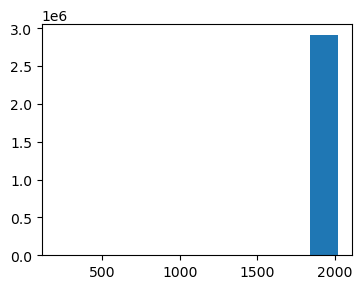

In [154]:
#years should only be in the range 1995 - 2020, but we also have outliers
plt.figure(figsize=(4,3))
plt.hist(ct['Year'])

In [155]:
#for 440 records we have an incorrect year - records to be deleted
ct[ct['Year'] < 1995]

,Region,Country,State,City,Month,Day,Year,AvgTemperature
58178,Africa,Ethiopia,NaN,Addis Ababa,12,3,201,-99.0
58179,Africa,Ethiopia,NaN,Addis Ababa,12,4,201,-99.0
58180,Africa,Ethiopia,NaN,Addis Ababa,12,5,201,-99.0
58181,Africa,Ethiopia,NaN,Addis Ababa,12,6,201,-99.0
58182,Africa,Ethiopia,NaN,Addis Ababa,12,7,201,-99.0
...,...,...,...,...,...,...,...,...
1212427,North America,Mexico,NaN,Guadalajara,12,27,201,-99.0
1212428,North America,Mexico,NaN,Guadalajara,12,28,201,-99.0
1212429,North America,Mexico,NaN,Guadalajara,12,29,201,-99.0
1212430,North America,Mexico,NaN,Guadalajara,12,30,201,-99.0


In [156]:
#dataset update
ct = ct[ct['Year'] >= 1995].reset_index().drop(columns = 'index')

In [157]:
#for 8 cases day = 0 - records to be deleted
ct[ct['Day']==0]

,Region,Country,State,City,Month,Day,Year,AvgTemperature
82745,Africa,Guinea,NaN,Conakry,3,0,2008,-99.0
85668,Africa,Guinea,NaN,Conakry,3,0,2016,-99.0
92012,Africa,Guinea-Bissau,NaN,Bissau,3,0,2008,-99.0
146019,Africa,Malawi,NaN,Lilongwe,3,0,2012,-99.0
177775,Africa,Nigeria,NaN,Lagos,3,0,2008,-99.0
241043,Africa,Uganda,NaN,Kampala,3,0,2012,-99.0
1209490,North America,Mexico,NaN,Guadalajara,3,0,2012,-99.0
1333470,South/Central America & Carribean,Cuba,NaN,Havana,3,0,2008,-99.0


In [158]:
#dataset update
ct = ct[ct['Day'] > 0].reset_index().drop(columns = 'index')
ct

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2905874,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2905875,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2905876,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2905877,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


In [159]:
#date created by joining year - month - day, add 0 if month/day < 10
ct['Date'] = ct.apply(lambda row: str(row['Year']) + '-0' + str(row['Month']) + '-0' + str(row['Day']) if row['Month'] < 10 and row['Day'] < 10 else (str(row['Year']) + '-' + str(row['Month']) + '-0' + str(row['Day']) if row['Month'] >= 10 and row['Day'] <10 else (str(row['Year']) + '-0' + str(row['Month']) + '-' + str(row['Day']) if row['Month'] < 10 and row['Day'] >= 10 else str(row['Year']) + '-' + str(row['Month']) + '-' + str(row['Day']))), axis=1) 

In [160]:
#type conversion from str to datetime
ct['Date'] = ct.apply(lambda row: pd.to_datetime(row['Date']), axis=1)

In [161]:
#selection of the most important columns
ct = ct[['Country', 'State', 'City', 'AvgTemperature', 'Date']]
ct

,Country,State,City,AvgTemperature,Date
0,Algeria,NaN,Algiers,64.2,1995-01-01
1,Algeria,NaN,Algiers,49.4,1995-01-02
2,Algeria,NaN,Algiers,48.8,1995-01-03
3,Algeria,NaN,Algiers,46.4,1995-01-04
4,Algeria,NaN,Algiers,47.9,1995-01-05
...,...,...,...,...,...
2905874,US,Additional Territories,San Juan Puerto Rico,82.4,2013-07-27
2905875,US,Additional Territories,San Juan Puerto Rico,81.6,2013-07-28
2905876,US,Additional Territories,San Juan Puerto Rico,84.2,2013-07-29
2905877,US,Additional Territories,San Juan Puerto Rico,83.8,2013-07-30


(array([7.922400e+04, 0.000000e+00, 8.900000e+01, 1.691000e+03,
        1.711600e+04, 1.225300e+05, 5.602180e+05, 9.706590e+05,
        1.102368e+06, 5.198400e+04]),
 array([-99. , -78.1, -57.2, -36.3, -15.4,   5.5,  26.4,  47.3,  68.2,
         89.1, 110. ]),
 <BarContainer object of 10 artists>)

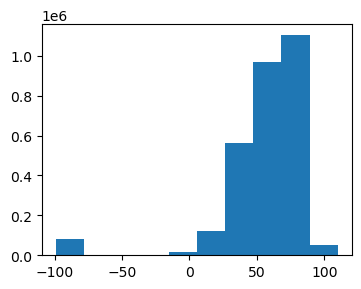

In [162]:
#checking the values of the average temperature
plt.figure(figsize=(4,3))
plt.hist(ct['AvgTemperature'])

In [163]:
#79 224 - records to replace
ct[ct['AvgTemperature'] == -99]

,Country,State,City,AvgTemperature,Date
220,Algeria,NaN,Algiers,-99.0,1995-08-09
221,Algeria,NaN,Algiers,-99.0,1995-08-10
408,Algeria,NaN,Algiers,-99.0,1996-02-13
409,Algeria,NaN,Algiers,-99.0,1996-02-14
1453,Algeria,NaN,Algiers,-99.0,1998-12-24
...,...,...,...,...,...
2905023,US,Additional Territories,San Juan Puerto Rico,-99.0,2011-03-29
2905086,US,Additional Territories,San Juan Puerto Rico,-99.0,2011-05-31
2905241,US,Additional Territories,San Juan Puerto Rico,-99.0,2011-11-02
2905278,US,Additional Territories,San Juan Puerto Rico,-99.0,2011-12-09


In [167]:
#the value -99 is actually null, replace it with np.nan
ct['AvgTemperature'] = ct.apply(lambda row: np.nan if row['AvgTemperature'] == -99 else row['AvgTemperature'], axis = 1)

In [166]:
#convert Temperature from Fahrenheit to Clsius
ct['AvgTemperature'] = ct.apply(lambda row: ConvertToCelsius(row['AvgTemperature']) if m.isnan(row['AvgTemperature']) == False else np.nan, axis=1)

(array([1.36000e+02, 1.14400e+03, 7.27300e+03, 3.49130e+04, 1.55297e+05,
        4.55017e+05, 6.98027e+05, 8.95155e+05, 5.57520e+05, 2.21730e+04]),
 array([-45.55555556, -36.66666667, -27.77777778, -18.88888889,
        -10.        ,  -1.11111111,   7.77777778,  16.66666667,
         25.55555556,  34.44444444,  43.33333333]),
 <BarContainer object of 10 artists>)

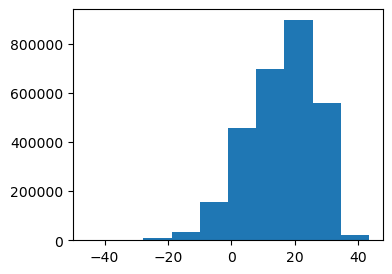

In [168]:
#histogram after data repair
plt.figure(figsize=(4,3))
plt.hist(ct['AvgTemperature'])

In [169]:
states = states.rename(columns = {'FullName': 'State'})

In [170]:
#adding a column with abbreviated state names, which will help in combining data with the US
ct_us = pd.merge(ct, states, how = 'left', on = 'State')

In [171]:
#for usa, we are interested in states, replacing city with state abbreviations so that they can be combined later
ct_us['City'] = ct_us.apply(lambda row: row['ShortName'] if row['Country'] == 'US' else row['City'], axis=1)
ct_us

,Country,State,City,AvgTemperature,Date,ShortName,Capital
0,Algeria,NaN,Algiers,17.888889,1995-01-01,NaN,NaN
1,Algeria,NaN,Algiers,9.666667,1995-01-02,NaN,NaN
2,Algeria,NaN,Algiers,9.333333,1995-01-03,NaN,NaN
3,Algeria,NaN,Algiers,8.000000,1995-01-04,NaN,NaN
4,Algeria,NaN,Algiers,8.833333,1995-01-05,NaN,NaN
...,...,...,...,...,...,...,...
2905874,US,Additional Territories,NaN,28.000000,2013-07-27,NaN,NaN
2905875,US,Additional Territories,NaN,27.555556,2013-07-28,NaN,NaN
2905876,US,Additional Territories,NaN,29.000000,2013-07-29,NaN,NaN
2905877,US,Additional Territories,NaN,28.777778,2013-07-30,NaN,NaN


In [191]:
#grouping and calculating the average, because by combining the states we have several values from the same day from one state
#but for different cities - we take the average
ct_us_gr = ct_us[['City', 'Country', 'Date', 'AvgTemperature']].groupby(by = ['City', 'Country', 'Date'], as_index = False).mean()
ct_us_gr = ct_us_gr.rename(columns = {'AvgTemperature': 'MeanTemperature'})
ct_us_gr = ct_us_gr.sort_values('MeanTemperature', ascending = False).reset_index().drop(columns = 'index')
ct_us_gr

,City,Country,Date,MeanTemperature
0,Kuwait,Kuwait,2012-08-01,43.333333
1,Kuwait,Kuwait,2017-06-29,43.277778
2,Kuwait,Kuwait,2005-07-17,43.277778
3,Kuwait,Kuwait,2012-08-02,43.277778
4,Kuwait,Kuwait,2015-07-17,43.277778
...,...,...,...,...
1907981,Zurich,Switzerland,2019-04-24,NaN
1907982,Zurich,Switzerland,2019-05-16,NaN
1907983,Zurich,Switzerland,2019-05-17,NaN
1907984,Zurich,Switzerland,2019-05-18,NaN


In [192]:
#list of countries that have different names in dataframes
country_list = list(ct_us_gr['Country'].unique())

for country in country_list:
    if country not in list(dict_country_new.values()):
        print(country)

US
Myanmar (Burma)
China
Taiwan
Gambia
Hong Kong
Suriname
Equador
South Korea
Serbia-Montenegro
North Korea
Turkey
Ivory Coast
Macedonia
The Netherlands
Slovakia
United Kingdom


In [193]:
#some countries had different names in the two DataFrame so in df_height the names were changed
ct_us_gr['Country'] = ct_us_gr['Country'].replace('US', 'United States')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('United Kingdom', 'Great Britain & N.I.')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Turkey', 'Türkiye')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('The Netherlands', 'Netherlands')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Taiwan', 'Chinese Taipei')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('South Korea', 'Korea')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Suriname', 'Surinam')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Serbia-Montenegro', 'Serbia')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Slovakia', 'Slovak Republic')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('North Korea', 'DPR of Korea')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Myanmar (Burma)', 'Myanmar')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Macedonia', 'Republic of North Macedonia')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Ivory Coast', 'Côte d’Ivoire')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Hong Kong', 'Hong Kong, China')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Gambia', 'The Gambia')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('China', 'PR of China')
ct_us_gr['Country'] = ct_us_gr['Country'].replace('Equador', 'Ecuador')

In [194]:
#after the change, all countries have the same names
country_list = list(ct_us_gr['Country'].unique())

for country in country_list:
    if country not in list(dict_country_new.values()):
        print(country)

In [195]:
#to connect the dataframe with the main one on the city, country and date, 
#you need to add a column with the abbreviation of the country name to the dataframe ct_us_gr
ct_us_gr['abb_country_competition'] = ct_us_gr.apply(lambda row: list(dict_country_new.keys())[list(dict_country_new.values()).index(row['Country'])], axis=1)

In [201]:
weather['Date'] = weather.apply(lambda row: pd.to_datetime(row['Date']), axis=1)

In [202]:
#connecting dataframes by city, country and date
weather = pd.merge(weather, ct_us_gr[['City', 'abb_country_competition', 'Date', 'MeanTemperature']], how = 'left', on = ['City', 'abb_country_competition', 'Date'])
weather

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition,MeanTemperature
0,Canberra,aus,2020-01-04,42.2,10.0,940.21,Fair,30.777778
1,Meknés,mar,2004-07-24,41.7,13.5,951.72,Fair,NaN
2,Sydney,aus,2011-02-05,41.1,20.0,1005.21,Fair / Windy,14.944444
3,Sydney,aus,2020-11-28,41.1,15.0,1003.52,Fair,NaN
4,Doha,qat,2021-05-28,40.6,15.5,1001.49,Fair,NaN
...,...,...,...,...,...,...,...,...
64208,Šumperk,cze,2022-05-14,NaN,NaN,NaN,NaN,NaN
64209,Żerków,pol,2017-05-13,NaN,NaN,NaN,NaN,NaN
64210,Żerków,pol,2018-05-12,NaN,NaN,NaN,NaN,NaN
64211,Żerków,pol,2019-05-18,NaN,NaN,NaN,NaN,NaN


In [203]:
#replacing the created temperatures with the missing ones
weather['Temperature'] = weather.apply(lambda row: row['MeanTemperature'] if m.isnan(row['Temperature']) else row['Temperature'], axis=1)

In [204]:
#the number of nan records for temperature has been reduced from 44 000 to 31 000
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64213 entries, 0 to 64212
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     64213 non-null  object        
 1   abb_country_competition  64213 non-null  object        
 2   Date                     64213 non-null  datetime64[ns]
 3   Temperature              33359 non-null  float64       
 4   Humidity                 20168 non-null  float64       
 5   Pressure                 20063 non-null  float64       
 6   Condition                19874 non-null  object        
 7   MeanTemperature          16545 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 4.4+ MB


The next records will be completed as the average temperature of the day for the cities of the country.

In [205]:
country_temp = ct_us_gr[['abb_country_competition', 'Date', 'MeanTemperature']].groupby(by = ['abb_country_competition', 'Date'], as_index = False).mean()
country_temp = country_temp.sort_values('MeanTemperature', ascending = False).reset_index().drop(columns = 'index')
country_temp

,abb_country_competition,Date,MeanTemperature
0,kuw,2012-08-01,43.333333
1,kuw,2012-08-02,43.277778
2,kuw,2017-06-29,43.277778
3,kuw,2005-07-17,43.277778
4,kuw,2015-07-17,43.277778
...,...,...,...
1101961,zam,2013-12-16,NaN
1101962,zam,2013-12-17,NaN
1101963,zam,2013-12-18,NaN
1101964,zam,2014-01-01,NaN


In [206]:
weather = pd.merge(weather[['City','abb_country_competition','Date','Temperature','Humidity','Pressure','Condition']], country_temp, how = 'left', on = ['abb_country_competition', 'Date'])
weather

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition,MeanTemperature
0,Canberra,aus,2020-01-04,42.2,10.0,940.21,Fair,24.577778
1,Meknés,mar,2004-07-24,41.7,13.5,951.72,Fair,33.166667
2,Sydney,aus,2011-02-05,41.1,20.0,1005.21,Fair / Windy,24.344444
3,Sydney,aus,2020-11-28,41.1,15.0,1003.52,Fair,NaN
4,Doha,qat,2021-05-28,40.6,15.5,1001.49,Fair,NaN
...,...,...,...,...,...,...,...,...
64208,Šumperk,cze,2022-05-14,NaN,NaN,NaN,NaN,NaN
64209,Żerków,pol,2017-05-13,NaN,NaN,NaN,NaN,15.388889
64210,Żerków,pol,2018-05-12,NaN,NaN,NaN,NaN,19.611111
64211,Żerków,pol,2019-05-18,NaN,NaN,NaN,NaN,NaN


In [207]:
weather['Temperature'] = weather.apply(lambda row: row['MeanTemperature'] if m.isnan(row['Temperature']) else row['Temperature'], axis=1)

In [208]:
#the number of nan records for temperature has been reduced from 31 000 to 14 000
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64213 entries, 0 to 64212
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     64213 non-null  object        
 1   abb_country_competition  64213 non-null  object        
 2   Date                     64213 non-null  datetime64[ns]
 3   Temperature              50082 non-null  float64       
 4   Humidity                 20168 non-null  float64       
 5   Pressure                 20063 non-null  float64       
 6   Condition                19874 non-null  object        
 7   MeanTemperature          45979 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 4.4+ MB


Next records will be completed with another dataset from kaggle.

In [209]:
#Daily weather data of all 194 country capitals (2018 - 2022 YTD)
#tavg - average temperature [C], pres - pressure [hPa]
dwd = pd.read_csv(path + '\daily_weather_data.csv')
dwd

,date,country,city,Latitude,Longitude,tavg,tmin,tmax,wdir,wspd,pres
0,21-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,23.4,20.9,25.5,329.0,9.3,1009.6
1,22-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,23.5,21.0,25.7,337.0,9.4,1010.0
2,23-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,23.5,21.1,25.5,41.0,8.2,1007.7
3,24-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,24.3,20.8,27.1,10.0,9.3,1004.4
4,25-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,26.5,22.7,30.0,9.0,9.7,1002.0
...,...,...,...,...,...,...,...,...,...,...,...
324642,07-10-2022,Western Sahara,El Aaiún,27.125287,-13.162500,22.1,18.6,25.6,3.0,24.7,1013.7
324643,08-10-2022,Western Sahara,El Aaiún,27.125287,-13.162500,22.1,19.6,25.6,2.0,20.5,1013.0
324644,09-10-2022,Western Sahara,El Aaiún,27.125287,-13.162500,23.4,19.6,29.6,34.0,24.0,1015.4
324645,10-10-2022,Western Sahara,El Aaiún,27.125287,-13.162500,23.1,18.6,29.7,39.0,28.4,1017.6


In [210]:
#the most important columns
dwd = dwd[['country', 'city', 'date', 'tavg', 'pres']]
dwd = dwd.rename(columns = {'city': 'City', 'date': 'Date'})
dwd

,country,City,Date,tavg,pres
0,Abkhazia,Sukhumi,21-07-2018,23.4,1009.6
1,Abkhazia,Sukhumi,22-07-2018,23.5,1010.0
2,Abkhazia,Sukhumi,23-07-2018,23.5,1007.7
3,Abkhazia,Sukhumi,24-07-2018,24.3,1004.4
4,Abkhazia,Sukhumi,25-07-2018,26.5,1002.0
...,...,...,...,...,...
324642,Western Sahara,El Aaiún,07-10-2022,22.1,1013.7
324643,Western Sahara,El Aaiún,08-10-2022,22.1,1013.0
324644,Western Sahara,El Aaiún,09-10-2022,23.4,1015.4
324645,Western Sahara,El Aaiún,10-10-2022,23.1,1017.6


In [211]:
#list of countries that have different names in dataframes
country_list = list(dwd['country'].unique())

for country in country_list:
    if country not in list(dict_country_new.values()):
        print(country)

Abkhazia
Aland Islands
Antigua and Barbuda
Bouvet Island
Cape Verde
China
Christmas Island
Cocos (Keeling) Islands
Congo (DRC)
Congo (Republic)
Côte d'Ivoire
Curaçao
Dominica
Falkland Islands (Islas Malvinas)
Faroe Islands
French Guiana
French Southern Territories
Gambia
Greenland
Guadeloupe
Guernsey
Hong Kong
Isle of Man
Jersey
Macau
Macedonia (FYROM)
Martinique
Mayotte
Myanmar (Burma)
New Caledonia
Niue
North Korea
Northern Cyprus
Pitcairn Islands
Réunion
Saint Pierre and Miquelon
Saint Vincent and the Grenadines
São Tomé and Príncipe
Slovakia
South Georgia and the South Sandwich Islands
South Korea
St. Barthélemy
St. Kitts and Nevis
St. Lucia
St. Martin
Suriname
Svalbard and Jan Mayen
Taiwan
Timor-Leste
Transnistria
Tristan da Cunha
U.S. Virgin Islands
United Kingdom
Vatican City
Wallis and Futuna
Western Sahara


In [212]:
#some countries had different names in the two DataFrame so in df_height the names were changed
dwd['country'] = dwd['country'].replace('Antigua and Barbuda', 'Antigua & Barbuda')
dwd['country'] = dwd['country'].replace('United Kingdom', 'Great Britain & N.I.')
dwd['country'] = dwd['country'].replace('China', 'PR of China')
dwd['country'] = dwd['country'].replace('Congo (DRC)', 'Democratic Republic of Congo')
dwd['country'] = dwd['country'].replace('Congo (Republic)', 'Congo')
dwd['country'] = dwd['country'].replace("Côte d'Ivoire", 'Côte d’Ivoire')
dwd['country'] = dwd['country'].replace('Dominica', 'Commonwealth of Dominica')
dwd['country'] = dwd['country'].replace('Gambia', 'The Gambia')
dwd['country'] = dwd['country'].replace('Hong Kong', 'Hong Kong, China')
dwd['country'] = dwd['country'].replace('Taiwan', 'Chinese Taipei')
dwd['country'] = dwd['country'].replace('South Korea', 'Korea')
dwd['country'] = dwd['country'].replace('Macedonia (FYROM)', 'Republic of North Macedonia')
dwd['country'] = dwd['country'].replace('Myanmar (Burma)', 'Myanmar')
dwd['country'] = dwd['country'].replace('North Korea', 'DPR of Korea')
dwd['country'] = dwd['country'].replace('Slovakia', 'Slovak Republic')
dwd['country'] = dwd['country'].replace('Suriname', 'Surinam')
dwd['country'] = dwd['country'].replace('Macau', 'Macao, China')
dwd['country'] = dwd['country'].replace('St. Kitts and Nevis', 'Saint Kitts and Nevis')
dwd['country'] = dwd['country'].replace('St. Lucia', 'Saint Lucia')
dwd['country'] = dwd['country'].replace('Saint Vincent and the Grenadines', 'Saint Vincent')

In [213]:
#some countries are in the dvd but not in the main table - you can get rid of them
country_list = list(dwd['country'].unique())
country_no = []
for country in country_list:
    if country not in list(dict_country_new.values()):
        country_no.append(country)

In [214]:
dwd['abb_country_competition'] = dwd.apply(lambda row: list(dict_country_new.keys())[list(dict_country_new.values()).index(row['country'])] if row['country'] not in country_no else np.nan, axis=1)

In [216]:
dwd['Date'] = dwd.apply(lambda row: pd.to_datetime(row['Date']), axis=1)

In [217]:
dwd

,country,City,Date,tavg,pres,abb_country_competition
0,Abkhazia,Sukhumi,2018-07-21,23.4,1009.6,NaN
1,Abkhazia,Sukhumi,2018-07-22,23.5,1010.0,NaN
2,Abkhazia,Sukhumi,2018-07-23,23.5,1007.7,NaN
3,Abkhazia,Sukhumi,2018-07-24,24.3,1004.4,NaN
4,Abkhazia,Sukhumi,2018-07-25,26.5,1002.0,NaN
...,...,...,...,...,...,...
324642,Western Sahara,El Aaiún,2022-07-10,22.1,1013.7,NaN
324643,Western Sahara,El Aaiún,2022-08-10,22.1,1013.0,NaN
324644,Western Sahara,El Aaiún,2022-09-10,23.4,1015.4,NaN
324645,Western Sahara,El Aaiún,2022-10-10,23.1,1017.6,NaN


In [218]:
#only capitals so we do country-country linking
weather = pd.merge(weather[['City','abb_country_competition','Date','Temperature','Humidity','Pressure','Condition']], dwd[['Date', 'abb_country_competition', 'tavg', 'pres',]], how = 'left', on = ['abb_country_competition', 'Date'])
weather

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition,tavg,pres
0,Canberra,aus,2020-01-04,42.200000,10.0,940.21,Fair,NaN,NaN
1,Meknés,mar,2004-07-24,41.700000,13.5,951.72,Fair,NaN,NaN
2,Sydney,aus,2011-02-05,41.100000,20.0,1005.21,Fair / Windy,NaN,NaN
3,Sydney,aus,2020-11-28,41.100000,15.0,1003.52,Fair,NaN,NaN
4,Doha,qat,2021-05-28,40.600000,15.5,1001.49,Fair,35.2,1003.9
...,...,...,...,...,...,...,...,...,...
64208,Šumperk,cze,2022-05-14,NaN,NaN,NaN,NaN,17.7,1020.1
64209,Żerków,pol,2017-05-13,15.388889,NaN,NaN,NaN,NaN,NaN
64210,Żerków,pol,2018-05-12,19.611111,NaN,NaN,NaN,0.7,1025.0
64211,Żerków,pol,2019-05-18,NaN,NaN,NaN,NaN,17.9,1011.3


In [219]:
weather['Temperature'] = weather.apply(lambda row: row['tavg'] if m.isnan(row['Temperature']) else row['Temperature'], axis=1)
weather['Pressure'] = weather.apply(lambda row: row['pres'] if m.isnan(row['Pressure']) else row['Pressure'], axis=1)

In [220]:
#the number of nan records for temperature has been reduced from 14 000 to 7 000 and for pressure from 44 000 to 34 000
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64213 entries, 0 to 64212
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     64213 non-null  object        
 1   abb_country_competition  64213 non-null  object        
 2   Date                     64213 non-null  datetime64[ns]
 3   Temperature              57255 non-null  float64       
 4   Humidity                 20168 non-null  float64       
 5   Pressure                 30551 non-null  float64       
 6   Condition                19874 non-null  object        
 7   tavg                     15374 non-null  float64       
 8   pres                     14533 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 4.9+ MB


Subsequent records completed as the average of the month for a given country.

In [221]:
dwd['year'] = dwd.apply(lambda row: row.Date.year, axis = 1)
dwd['month'] = dwd.apply(lambda row: row.Date.month, axis = 1)

In [222]:
#grouping by city, country and combined year with month
dwd_ym = dwd[['City', 'country', 'year', 'month', 'tavg', 'pres']].groupby(by = ['City', 'country', 'year', 'month'], as_index= False).mean()

In [223]:
dwd_ym['abb_country_competition'] = dwd_ym.apply(lambda row: list(dict_country_new.keys())[list(dict_country_new.values()).index(row['country'])] if row['country'] not in country_no else np.nan, axis=1)
dwd_ym.head()

,City,country,year,month,tavg,pres,abb_country_competition
0,Abu Dhabi,United Arab Emirates,2018,1,22.387097,1013.100000,uae
1,Abu Dhabi,United Arab Emirates,2018,2,26.035714,1011.159259,uae
2,Abu Dhabi,United Arab Emirates,2018,3,26.316129,1010.475862,uae
3,Abu Dhabi,United Arab Emirates,2018,4,29.663333,1008.510345,uae
4,Abu Dhabi,United Arab Emirates,2018,5,31.535484,1006.362500,uae


In [224]:
weather['year'] = weather.apply(lambda row: row.Date.year, axis = 1)
weather['month'] = weather.apply(lambda row: row.Date.month, axis = 1)

In [225]:
weather.head()

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition,tavg,pres,year,month
0,Canberra,aus,2020-01-04,42.2,10.0,940.21,Fair,NaN,NaN,2020,1
1,Meknés,mar,2004-07-24,41.7,13.5,951.72,Fair,NaN,NaN,2004,7
2,Sydney,aus,2011-02-05,41.1,20.0,1005.21,Fair / Windy,NaN,NaN,2011,2
3,Sydney,aus,2020-11-28,41.1,15.0,1003.52,Fair,NaN,NaN,2020,11
4,Doha,qat,2021-05-28,40.6,15.5,1001.49,Fair,35.2,1003.9,2021,5


In [226]:
weather = pd.merge(weather[['City', 'abb_country_competition', 'Date', 'Temperature', 'Humidity', 'Pressure', 'Condition', 'year', 'month']], dwd_ym[['year', 'month', 'tavg', 'pres', 'abb_country_competition']], how = 'left', on = ['abb_country_competition', 'year', 'month'])

In [227]:
weather['Temperature'] = weather.apply(lambda row: row['tavg'] if m.isnan(row['Temperature']) else row['Temperature'], axis=1)
weather['Pressure'] = weather.apply(lambda row: row['pres'] if m.isnan(row['Pressure']) else row['Pressure'], axis=1)
weather

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition,year,month,tavg,pres
0,Canberra,aus,2020-01-04,42.200000,10.0,940.21,Fair,2020,1,NaN,NaN
1,Meknés,mar,2004-07-24,41.700000,13.5,951.72,Fair,2004,7,NaN,NaN
2,Sydney,aus,2011-02-05,41.100000,20.0,1005.21,Fair / Windy,2011,2,NaN,NaN
3,Sydney,aus,2020-11-28,41.100000,15.0,1003.52,Fair,2020,11,NaN,NaN
4,Doha,qat,2021-05-28,40.600000,15.5,1001.49,Fair,2021,5,31.803226,1005.716129
...,...,...,...,...,...,...,...,...,...,...,...
64208,Šumperk,cze,2022-05-14,17.700000,NaN,1020.10,NaN,2022,5,16.400000,1016.648276
64209,Żerków,pol,2017-05-13,15.388889,NaN,NaN,NaN,2017,5,NaN,NaN
64210,Żerków,pol,2018-05-12,19.611111,NaN,1025.00,NaN,2018,5,16.087097,1017.141935
64211,Żerków,pol,2019-05-18,17.900000,NaN,1011.30,NaN,2019,5,13.764516,1013.061290


In [228]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64213 entries, 0 to 64212
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     64213 non-null  object        
 1   abb_country_competition  64213 non-null  object        
 2   Date                     64213 non-null  datetime64[ns]
 3   Temperature              57507 non-null  float64       
 4   Humidity                 20168 non-null  float64       
 5   Pressure                 31131 non-null  float64       
 6   Condition                19874 non-null  object        
 7   year                     64213 non-null  int64         
 8   month                    64213 non-null  int64         
 9   tavg                     15713 non-null  float64       
 10  pres                     15308 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 5.9+ MB


Going back to the first dataset from kaggle and also completing the average temperature of the month for the country.

In [229]:
country_temp['year'] = country_temp.apply(lambda row: row.Date.year, axis = 1)
country_temp['month'] = country_temp.apply(lambda row: row.Date.month, axis = 1)

In [230]:
country_ym = country_temp[['abb_country_competition', 'year', 'month', 'MeanTemperature']].groupby(by = ['abb_country_competition', 'year', 'month'], as_index= False).mean()
country_ym

,abb_country_competition,year,month,MeanTemperature
0,alb,1995,1,NaN
1,alb,1995,2,NaN
2,alb,1995,3,NaN
3,alb,1995,4,NaN
4,alb,1995,5,NaN
...,...,...,...,...
36271,zam,2013,9,22.098765
36272,zam,2013,10,25.638889
36273,zam,2013,11,25.465608
36274,zam,2013,12,23.381313


In [231]:
weather = pd.merge(weather[['City', 'abb_country_competition', 'Date', 'Temperature', 'Humidity', 'Pressure', 'Condition', 'year', 'month']], country_ym, how = 'left', on = ['abb_country_competition', 'year', 'month'])

In [232]:
weather['Temperature'] = weather.apply(lambda row: row['MeanTemperature'] if m.isnan(row['Temperature']) else row['Temperature'], axis=1)

In [233]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64213 entries, 0 to 64212
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     64213 non-null  object        
 1   abb_country_competition  64213 non-null  object        
 2   Date                     64213 non-null  datetime64[ns]
 3   Temperature              57617 non-null  float64       
 4   Humidity                 20168 non-null  float64       
 5   Pressure                 31131 non-null  float64       
 6   Condition                19874 non-null  object        
 7   year                     64213 non-null  int64         
 8   month                    64213 non-null  int64         
 9   MeanTemperature          46263 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 5.4+ MB


Temperature records are still empty for over 6 500 records and pressure over 33 000, the rest will be filled in based on the existing ones = average for a given month for the country in different years.

In [234]:
wea_month = weather[['abb_country_competition', 'month', 'Temperature', 'Pressure']].groupby(by = ['abb_country_competition', 'month'], as_index= False).mean()
wea_month = wea_month.rename(columns = {'Temperature': 'temp', 'Pressure': 'pres'})
wea_month.head()

,abb_country_competition,month,temp,pres
0,aho,2,NaN,NaN
1,aho,3,26.944828,1013.048276
2,aho,4,NaN,NaN
3,aho,5,NaN,NaN
4,aho,6,27.700000,1012.300000


In [235]:
weather = pd.merge(weather[['City', 'abb_country_competition', 'Date', 'Temperature', 'Humidity', 'Pressure', 'Condition', 'year', 'month']], wea_month, how = 'left', on = ['abb_country_competition', 'month'])

In [236]:
weather['Temperature'] = weather.apply(lambda row: row['temp'] if m.isnan(row['Temperature']) else row['Temperature'], axis=1)
weather['Pressure'] = weather.apply(lambda row: row['pres'] if m.isnan(row['Pressure']) else row['Pressure'], axis=1)

In [237]:
#the number of nan records for temperature has been reduced from 6 500 to 1 000 and for pressure from 33 000 to 4 000
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64213 entries, 0 to 64212
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     64213 non-null  object        
 1   abb_country_competition  64213 non-null  object        
 2   Date                     64213 non-null  datetime64[ns]
 3   Temperature              63179 non-null  float64       
 4   Humidity                 20168 non-null  float64       
 5   Pressure                 60172 non-null  float64       
 6   Condition                19874 non-null  object        
 7   year                     64213 non-null  int64         
 8   month                    64213 non-null  int64         
 9   temp                     63179 non-null  float64       
 10  pres                     60172 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 5.9+ MB


The remaining empty records for temperature and pressure will be populated as a country average.

In [238]:
wea_country = weather[['abb_country_competition', 'Temperature', 'Pressure']].groupby(by = ['abb_country_competition'], as_index= False).mean()
wea_country = wea_country.rename(columns = {'Temperature': 'temp', 'Pressure': 'pres'})
wea_country.head()

,abb_country_competition,temp,pres
0,aho,27.548966,1012.449655
1,alb,18.573737,1012.000000
2,alg,22.037244,1014.187959
3,and,NaN,NaN
4,ang,NaN,NaN


In [239]:
weather = pd.merge(weather[['City', 'abb_country_competition', 'Date', 'Temperature', 'Humidity', 'Pressure', 'Condition', 'year', 'month']], wea_country, how = 'left', on = ['abb_country_competition'])

In [240]:
weather['Temperature'] = weather.apply(lambda row: row['temp'] if m.isnan(row['Temperature']) else row['Temperature'], axis=1)
weather['Pressure'] = weather.apply(lambda row: row['pres'] if m.isnan(row['Pressure']) else row['Pressure'], axis=1)

In [241]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64213 entries, 0 to 64212
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     64213 non-null  object        
 1   abb_country_competition  64213 non-null  object        
 2   Date                     64213 non-null  datetime64[ns]
 3   Temperature              63340 non-null  float64       
 4   Humidity                 20168 non-null  float64       
 5   Pressure                 60440 non-null  float64       
 6   Condition                19874 non-null  object        
 7   year                     64213 non-null  int64         
 8   month                    64213 non-null  int64         
 9   temp                     63340 non-null  float64       
 10  pres                     60440 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 5.9+ MB


In [242]:
weather.to_csv(path+ '\weather_new.csv')

The remaining empty records for temperature and pressure will be populated as an average for a given month for the neighbours of country in different years.

In [243]:
#lists of countries for which the temperature or pressure is empty
country_temp = list(weather['abb_country_competition'][weather['Temperature'].isna()].unique())
country_press = list(weather['abb_country_competition'][weather['Pressure'].isna()].unique())
country_list = set(country_temp + country_press)

In [244]:
def countries(abb):
    country = weather[weather['abb_country_competition'] == abb]
    t = country[country['Temperature'].isna()]
    p = country[country['Pressure'].isna()]
    return len(t), len(p)

In [245]:
#a dictionary showing whether the temperature/pressure is missing for a given country and how much
country_temp_pres = {}
for c in country_list:
    country_temp_pres[dict_country_new[c]] = countries(c)
country_temp_pres

{'Guatemala': (0, 21),
 'Lesotho': (3, 3),
 'Costa Rica': (0, 30),
 'Czechoslovakia': (64, 64),
 'Botswana': (53, 53),
 'South Africa': (0, 805),
 'Namibia': (0, 42),
 'Ethiopia': (0, 23),
 'Aruba': (1, 1),
 'Samoa': (0, 7),
 'Nrd': (49, 49),
 'Angola': (2, 2),
 'Switzerland': (0, 1201),
 'Zambia': (0, 27),
 'Andorra': (8, 8),
 'Turks and Caicos Islands': (1, 1),
 'Tonga': (1, 1),
 'Nepal': (0, 8),
 'Gabon': (1, 1),
 'Tanzania': (0, 4),
 'Guam': (1, 1),
 'Nigeria': (0, 209),
 'Islamic Republic of Iran': (108, 108),
 'Malaysia': (0, 181),
 'Zimbabwe': (22, 22),
 'Mongolia': (0, 3),
 'Madagascar': (0, 8),
 'Myanmar': (0, 5),
 'Norfolk Island': (1, 1),
 'Vanuatu': (0, 4),
 'Belize': (1, 1),
 'Ussr': (165, 165),
 'Sudan': (3, 3),
 'Bulgaria': (0, 228),
 'Rfn': (23, 23),
 'American Samoa': (3, 3),
 'Chile': (355, 355),
 'Brunei': (8, 8),
 'Yugoslavia': (0, 3),
 'Honduras': (0, 5),
 'Saudi Arabia': (0, 86)}

In [246]:
#Neighbours of countries:
neighbours = {'Mongolia': ['PR of China', 'Russia', 'Kazakhstan'], 
    'Nepal': ['PR of China', 'India'],
    'Malaysia': ['Brunei', 'Indonesia', 'Thailand'],
    'Brunei': ['Malaysia'],
    'Myanmar': ['Thailand', 'Laos', 'PR of China', 'India', 'Bangladesh'],
    'Saudi Arabia': ['Iraq', 'Jordan', 'Kuwait', 'Oman', 'Qatar', 'United Arab Emirates', 'Republic of Yemen'],
    'Islamic Republic of Iran': ['Afghanistan', 'Armenia', 'Azerbaijan', 'Iraq', 'Pakistan', 'Türkiye', 'Turkmenistan'],
    'Sudan': ['Central African Republic', 'Chad', 'Egypt', 'Eritrea', 'Ethiopia', 'Libya', 'South Sudan'],
    'Ethiopia': ['Eritrea', 'Somalia', 'Kenya', 'South Sudan', 'Sudan'],
    'Zambia': ['Angola', 'Botswana', 'Democratic Republic of Congo', 'Malawi', 'Mozambique', 'Namibia', 'Tanzania', 'Zimbabwe'],
    'Angola': ['Congo', 'Democratic Republic of Congo, Zambia', 'Namibia'],
    'Zimbabwe': ['Mozambique', 'Botswana', 'Zambia', 'Namibia', 'South Africa'],
    'Botswana': ['Namibia', 'Zambia', 'Zimbabwe', 'South Africa'],
    'Namibia': ['Botswana', 'Zambia', 'Zimbabwe'],
    'South Africa': ['Namibia', 'Botswana', 'Zimbabwe', 'Eswatini'],
    'Lesotho': ['South Africa'],
    'Nigeria': ['Niger', 'Chad', 'Cameroon', 'Benin'],
    'Tanzania': ['Kenya', 'Uganda', 'Rwanda', 'Burundi', 'Democratic Republic of Congo', 'Zambia', 'Malawi', 'Mozambique'],
    'Madagascar': ['Mozambique'],
    'Gabon': ['Cameroon', 'Equatorial Guinea', 'Congo'],
    'Costa Rica': ['Nicaragua', 'Panama'],
    'Guatemala': ['Mexico', 'Honduras', 'El Salvador', 'Belize'],
    'Belize': ['Mexico', 'Guatemala'],
    'Honduras': ['Guatemala', 'Nicaragua', 'El Salvador'],
    'Chile': ['Argentina', 'Bolivia', 'Peru'],
    'Aruba': ['Venezuela'],
    'Turks and Caicos Islands': ['Haiti', 'Dominican Republic'],
    'Vanuatu': ['Fiji', 'Australia'],
    'American Samoa': ['Samoa', 'Tonga', 'New Zealand'],
    'Samoa': ['Tonga', 'New Zealand'],
    'Tonga': ['Fiji', 'Cook Islands', 'Samoa', 'American Samoa'],
    'Norfolk Island': ['New Zealand'],
    'Guam': ['Papua New Guinea', 'Philippines'],
    'Bulgaria': ['Greece', 'Republic of North Macedonia', 'Romania', 'Serbia', 'Türkiye'],
    'Yugoslavia': ['Bosnia-Herzegovina', 'Croatia', 'Kosovo', 'Montenegro', 'Republic of North Macedonia', 'Serbia', 'Slovenia'],
    'Switzerland': ['Austria', 'France', 'Germany', 'Italy', 'Liechtenstein'],
    'Zsrr': ['Russia', 'Lithuania','Georgia','Estonia','Latvia','Ukraine','Moldova','Kyrgyzstan','Uzbekistan','Tajikistan','Armenia','Azerbaijan','Turkmenistan','Belarus','Kazakhstan'],
    'Czechoslovakia': ['Slovak Republic', 'Czech Republic'],
    'Nrd': ['Germany'],
    'Rfn': ['Germany'],
    'Andorra': ['Spain', 'France']}

In [247]:
weather['country'] = change_country(weather['abb_country_competition'])
weather

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition,year,month,temp,pres,country
0,Canberra,aus,2020-01-04,42.200000,10.0,940.210000,Fair,2020,1,21.611839,1003.526028,Australia
1,Meknés,mar,2004-07-24,41.700000,13.5,951.720000,Fair,2004,7,22.594221,991.504275,Morocco
2,Sydney,aus,2011-02-05,41.100000,20.0,1005.210000,Fair / Windy,2011,2,21.611839,1003.526028,Australia
3,Sydney,aus,2020-11-28,41.100000,15.0,1003.520000,Fair,2020,11,21.611839,1003.526028,Australia
4,Doha,qat,2021-05-28,40.600000,15.5,1001.490000,Fair,2021,5,29.197714,1008.317463,Qatar
...,...,...,...,...,...,...,...,...,...,...,...,...
64208,Šumperk,cze,2022-05-14,17.700000,NaN,1020.100000,NaN,2022,5,17.435654,989.327837,Czech Republic
64209,Żerków,pol,2017-05-13,15.388889,NaN,1001.400863,NaN,2017,5,17.690964,1002.077828,Poland
64210,Żerków,pol,2018-05-12,19.611111,NaN,1025.000000,NaN,2018,5,17.690964,1002.077828,Poland
64211,Żerków,pol,2019-05-18,17.900000,NaN,1011.300000,NaN,2019,5,17.690964,1002.077828,Poland


In [248]:
months = []
condi = []
for country in neighbours.keys():             #months for a given country with empty temperature or pressure
    months = list(weather[['month']][weather['country'] == country]['month'])
    
    con = False        #creating a condition starting with False and adding the possibility of a neighbor
    for neigh in neighbours[country]:
        con |= (weather['country'] == neigh)
        
    for mo in months:  #we go through the next months
        cond = weather[(con) & (weather.month == mo)]     # we add the occurring month to the condition
        if country_temp_pres[country][0] > 0:            #we check if a given country lacks temperature or pressure or both
            col = 'Temperature'             
            mean = cond[col].mean()                      #average calculation       #value substitution into dataframe
            weather.loc[(weather['country'] == country) & (weather['month'] == mo), col] = mean
            
        if country_temp_pres[country][1] > 0:
            col = 'Pressure'
            mean = cond[col].mean()
            weather.loc[(weather['country'] == country) & (weather['month'] == mo), col] = mean

In [249]:
#temperature was completed for all records, 167 empty records were left for pressure
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64213 entries, 0 to 64212
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     64213 non-null  object        
 1   abb_country_competition  64213 non-null  object        
 2   Date                     64213 non-null  datetime64[ns]
 3   Temperature              64048 non-null  float64       
 4   Humidity                 20168 non-null  float64       
 5   Pressure                 63881 non-null  float64       
 6   Condition                19874 non-null  object        
 7   year                     64213 non-null  int64         
 8   month                    64213 non-null  int64         
 9   temp                     63340 non-null  float64       
 10  pres                     60440 non-null  float64       
 11  country                  64213 non-null  object        
dtypes: datetime64[ns](1), float64(5)

The remaining empty pressure records will be refilled as the country average.

In [250]:
wea_country2 = weather[['abb_country_competition', 'Pressure']].groupby(by = ['abb_country_competition'], as_index= False).mean()
wea_country2 = wea_country2.rename(columns = {'Pressure': 'pres'})
wea_country2.head()

,abb_country_competition,pres
0,aho,1012.449655
1,alb,1012.000000
2,alg,1014.187959
3,and,999.146016
4,ang,1010.200000


In [251]:
weather = weather.drop(columns = ['temp', 'pres'])

In [252]:
weather = pd.merge(weather, wea_country2, how = 'left', on = ['abb_country_competition'])

In [253]:
weather['Pressure'] = weather.apply(lambda row: row['pres'] if m.isnan(row['Pressure']) else row['Pressure'], axis=1)

In [254]:
weather = weather.drop(columns = ['year', 'month', 'country', 'pres'])
weather.head()

,City,abb_country_competition,Date,Temperature,Humidity,Pressure,Condition
0,Canberra,aus,2020-01-04,42.2,10.0,940.21,Fair
1,Meknés,mar,2004-07-24,41.7,13.5,951.72,Fair
2,Sydney,aus,2011-02-05,41.1,20.0,1005.21,Fair / Windy
3,Sydney,aus,2020-11-28,41.1,15.0,1003.52,Fair
4,Doha,qat,2021-05-28,40.6,15.5,1001.49,Fair


In [255]:
#temperature and pressure were completed for all records
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64213 entries, 0 to 64212
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     64213 non-null  object        
 1   abb_country_competition  64213 non-null  object        
 2   Date                     64213 non-null  datetime64[ns]
 3   Temperature              64048 non-null  float64       
 4   Humidity                 20168 non-null  float64       
 5   Pressure                 64048 non-null  float64       
 6   Condition                19874 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 3.9+ MB


In [256]:
weather.to_csv(path + '\weather_temp_pres.csv')

In [257]:
weather = weather.rename(columns = {'City': 'city_competition', 'Date': 'date_competition'})

### Linking the weather to the main table

In [258]:
df_all3 = pd.merge(df_all2, weather, how = 'left', on = ['city_competition', 'abb_country_competition', 'date_competition'])
df_all3

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,month,start_career,start_season,pb,sb,height,Temperature,Humidity,Pressure,Condition
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,...,7,1,1,NaN,NaN,473.0,35.000000,26.5,1000.810000,Fair
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,...,7,2,1,11.40,NaN,61.0,17.141071,NaN,1008.029107,NaN
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,...,7,3,2,11.40,NaN,61.0,22.800000,69.0,1011.980000,Fair
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,...,7,4,3,11.40,NaN,61.0,22.800000,69.0,1011.980000,Fair
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,...,6,5,1,11.21,NaN,164.0,18.555556,NaN,1005.761693,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,...,11,1,1,NaN,NaN,438.0,11.400000,NaN,1018.700000,NaN
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,...,10,1,1,NaN,NaN,438.0,17.800000,83.0,1021.130000,Light Rain
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,...,10,2,2,10.71,10.71,438.0,17.800000,83.0,1021.130000,Light Rain
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,...,10,1,1,NaN,NaN,438.0,21.100000,80.5,1015.880000,Mostly Cloudy


In [262]:
df_all3.to_csv(path + '\df_all_temp_pres.csv')

# Results analysis

In [263]:
df_all3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581277 entries, 0 to 581276
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   name                     581277 non-null  object        
 1   country                  581277 non-null  object        
 2   abb_coun                 581277 non-null  object        
 3   number                   581277 non-null  int64         
 4   birth_date               495759 non-null  datetime64[ns]
 5   url_athlete              581277 non-null  object        
 6   result                   581277 non-null  float64       
 7   date_competition         581277 non-null  datetime64[ns]
 8   abb_country_competition  581277 non-null  object        
 9   city_competition         581277 non-null  object        
 10  wind                     546387 non-null  float64       
 11  country_competition      581277 non-null  object        
 12  age             

In [264]:
df_all3.describe()

,number,result,wind,age,if_country,year,month,start_career,start_season,pb,sb,height,Temperature,Humidity,Pressure
count,5.812770e+05,581277.000000,546387.000000,495759.000000,581277.000000,581277.000000,581277.000000,581277.000000,581277.000000,531202.000000,421584.000000,580198.000000,580823.000000,244443.000000,580823.000000
mean,1.450211e+07,10.818872,0.614940,22.326540,0.818414,2013.326120,5.756436,25.753974,4.553595,10.635686,10.718860,540.286740,20.050928,62.026837,1003.535579
std,2.513533e+05,0.416071,1.524939,4.265904,0.385504,7.481966,1.956022,33.039361,3.870500,0.343726,0.333779,338.235359,5.947073,17.649942,28.295766
min,1.416460e+07,9.580000,-9.000000,-10.100000,0.000000,1955.000000,1.000000,1.000000,1.000000,9.580000,9.580000,1.000000,-19.800000,5.000000,625.000000
25%,1.423859e+07,10.600000,-0.300000,19.170000,1.000000,2010.000000,4.000000,6.000000,2.000000,10.390000,10.490000,320.000000,16.100000,50.000000,1002.555569
50%,1.447617e+07,10.830000,0.600000,21.620000,1.000000,2015.000000,6.000000,14.000000,3.000000,10.660000,10.740000,460.000000,20.000000,63.000000,1011.980000
75%,1.470666e+07,11.020000,1.500000,24.760000,1.000000,2019.000000,7.000000,32.000000,6.000000,10.890000,10.950000,760.000000,24.200000,75.000000,1016.673213
max,1.505413e+07,73.960000,16.600000,57.710000,1.000000,2022.000000,12.000000,384.000000,43.000000,23.530000,47.530000,3265.000000,42.200000,100.000000,1043.000000


### age analysis

In [265]:
#ok, 57 makes sense
df_all3['age'].max()

57.71

In [266]:
#error, age cannot be negative
df_all3['age'].min()

-10.1

In [267]:
#three situations where age is negative
#date of birth and dates of races agree with the data from the source (iaaf website), so the error is due to the data on website
#you can delete these records or replace the competition date and thus the age and year with nan
df_all3[df_all3['age'] < 0]

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,month,start_career,start_season,pb,sb,height,Temperature,Humidity,Pressure,Condition
180546,Joe FRANKLIN,United States,usa,14344410,1978-07-11,https://www.worldathletics.org/athletes/United...,10.00,1976-05-01,usa,LA,...,5,1,1,NaN,NaN,760.0,17.880388,NaN,1018.222960,NaN
180547,Joe FRANKLIN,United States,usa,14344410,1978-07-11,https://www.worldathletics.org/athletes/United...,10.46,1976-06-11,usa,CA,...,6,2,2,NaN,NaN,760.0,21.816830,NaN,1016.897830,NaN
183657,Carl EDMUND,Panama,pan,14351322,1983-03-31,https://www.worldathletics.org/athletes/Panama...,10.40,1973-02-24,pan,Panama City,...,2,1,1,NaN,NaN,360.0,28.591503,NaN,1007.877255,NaN


Text(0.5, 1.0, 'Age histogram')

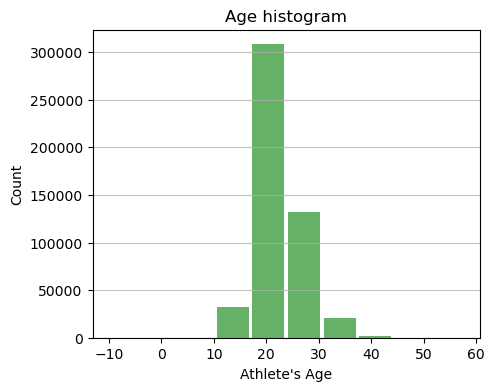

In [268]:
plt.figure(figsize=(5,4))
plt.hist(df_all3['age'], bins = 10, alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Athlete's Age")
plt.ylabel('Count')
plt.title('Age histogram')

In [270]:
#there are also isolated cases when age < 10 - in total 17
df_all3[df_all3['age'] < 10]

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,month,start_career,start_season,pb,sb,height,Temperature,Humidity,Pressure,Condition
119752,Aleksandr CHIZHOV,Russia,rus,14222012,1991-02-18,https://www.worldathletics.org/athletes/Russia...,10.80,1998-05-30,rus,Bryansk,...,5,1,1,NaN,NaN,600.0,18.194444,NaN,1002.555569,NaN
133756,Burak KARAKAŞ,Türkiye,tur,14229403,2001-04-04,https://www.worldathletics.org/athletes/Türkiy...,11.00,2003-06-08,tur,Istanbul,...,6,1,1,NaN,NaN,1141.0,23.055556,NaN,973.310380,NaN
134147,Dmytro BONDAREV,Ukraine,ukr,14229766,1993-10-03,https://www.worldathletics.org/athletes/Ukrain...,10.93,1999-05-14,ukr,Kyiv,...,5,1,1,NaN,NaN,175.0,7.200000,100.0,988.620000,Cloudy
143977,Bobby EZELL,United States,usa,14237460,1989-01-01,https://www.worldathletics.org/athletes/United...,10.53,1998-05-15,usa,IL,...,5,1,1,NaN,NaN,760.0,24.555556,NaN,1018.222960,NaN
160839,James SCOTT,United States,usa,14250820,1980-09-16,https://www.worldathletics.org/athletes/United...,10.47,1987-05-30,usa,MO,...,5,1,1,NaN,NaN,760.0,17.880388,NaN,1018.222960,NaN
168563,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.82,2008-03-08,jam,Spanish Town,...,3,1,1,NaN,NaN,340.0,26.100000,69.0,1015.880000,Fair
168564,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.94,2009-03-14,jam,Spanish Town,...,3,2,1,NaN,NaN,340.0,26.700000,61.0,1015.370000,Fair
168565,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.80,2010-02-13,jam,Spanish Town,...,2,3,1,NaN,NaN,340.0,26.700000,67.0,1009.280000,Mostly Cloudy
168566,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,11.03,2010-03-13,jam,Spanish Town,...,3,4,2,NaN,NaN,340.0,27.500000,72.0,1009.280000,Fair
168567,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,11.05,2010-04-17,jam,Kingston,...,4,5,3,11.03,11.03,340.0,25.600000,78.5,1010.290000,Mostly Cloudy


In [271]:
#searching for numbers of athletes who are < 10 years old. 
#If age < 0, the value is -1, if between 0 and 10, the value is 0, and if age > 10 value is 1.
numbers = []
def age_number(row):
    if row['age'] < 0:
        value = -1
    elif row['age'] >= 0 and row['age'] < 10:
        value = 0
        if row['number'] not in numbers:
            numbers.append(row['number'])
    else:
        value = 1    
    return value

df_all3['value'] = df_all3.apply(lambda row: age_number(row), axis=1)

In [272]:
#if the competitor is under the age of 10 and has not run in the next two years, the records go to the wrong ones, value = -1
#if the competitor is under the age of 10 and ran in the next two years, the records go to the suspects, value = 0
for i in range(len(df_all3)):
    if df_all3['number'][i] in numbers and df_all3['age'][i] < 10 and df_all3['age'][i+1] > 10 and df_all3['age'][i+1] - df_all3['age'][i] < 2:
        numbers.remove(df_all3['number'][i])

df_all3['value'] = df_all3.apply(lambda row: -1 if row['number'] in numbers and row['age'] < 10 else row['value'], axis=1)

In [274]:
#a total of seven records are considered incorrect - convert to np.nan
df_all3['date_competition'][df_all3['value'] == -1] = [np.nan] * len(df_all3[df_all3['value'] == -1])
df_all3['year'][df_all3['value'] == -1] = [np.nan] * len(df_all3[df_all3['value'] == -1])
df_all3['month'][df_all3['value'] == -1] = [np.nan] * len(df_all3[df_all3['value'] == -1])
df_all3['age'][df_all3['value'] == -1] = [np.nan] * len(df_all3[df_all3['value'] == -1])

In [275]:
df_all3['date_competition'].replace(np.nan, pd.NaT, inplace=True)

In [276]:
#and 10 as suspicious
df_all3[df_all3['value'] == 0]

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,start_career,start_season,pb,sb,height,Temperature,Humidity,Pressure,Condition,value
143977,Bobby EZELL,United States,usa,14237460,1989-01-01,https://www.worldathletics.org/athletes/United...,10.53,1998-05-15,usa,IL,...,1,1,NaN,NaN,760.0,24.555556,NaN,1018.222960,NaN,0
168563,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.82,2008-03-08,jam,Spanish Town,...,1,1,NaN,NaN,340.0,26.100000,69.0,1015.880000,Fair,0
168564,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.94,2009-03-14,jam,Spanish Town,...,2,1,NaN,NaN,340.0,26.700000,61.0,1015.370000,Fair,0
168565,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,10.80,2010-02-13,jam,Spanish Town,...,3,1,NaN,NaN,340.0,26.700000,67.0,1009.280000,Mostly Cloudy,0
168566,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,11.03,2010-03-13,jam,Spanish Town,...,4,2,NaN,NaN,340.0,27.500000,72.0,1009.280000,Fair,0
168567,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,11.05,2010-04-17,jam,Kingston,...,5,3,11.03,11.03,340.0,25.600000,78.5,1010.290000,Mostly Cloudy,0
168568,Jemar JOHNSON,Jamaica,jam,14325646,2000-10-20,https://www.worldathletics.org/athletes/Jamaic...,11.01,2010-05-28,jam,Spanish Town,...,6,4,11.03,11.03,340.0,25.000000,78.0,1008.600000,Mostly Cloudy,0
196907,Christian HUBBARD,United States,usa,14367089,2002-03-02,https://www.worldathletics.org/athletes/United...,10.79,2009-03-27,usa,TX,...,1,1,NaN,NaN,760.0,14.900794,NaN,1016.941602,NaN,0
196908,Christian HUBBARD,United States,usa,14367089,2002-03-02,https://www.worldathletics.org/athletes/United...,11.20,2009-03-28,usa,TX,...,2,2,NaN,NaN,760.0,8.551587,NaN,1016.941602,NaN,0
196909,Christian HUBBARD,United States,usa,14367089,2002-03-02,https://www.worldathletics.org/athletes/United...,11.18,2011-04-30,usa,TX,...,3,1,11.20,NaN,760.0,24.718254,NaN,1015.751857,NaN,0


In [277]:
#now the smallest age is 7
df_all3['age'].min()

7.07

Text(0.5, 1.0, 'Age histogram')

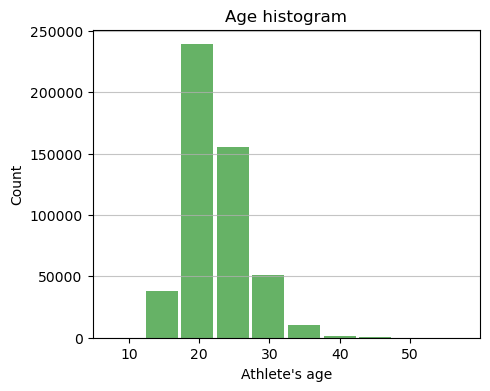

In [278]:
#histogram with corrected data
plt.figure(figsize=(5,4))
plt.hist(df_all3['age'], bins = 10, alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Athlete's age")
plt.ylabel('Count')
plt.title('Age histogram')

### wind analysis

In [280]:
df_all3['wind'].max()

16.6

In [281]:
df_all3['wind'].min()

-9.0

Text(0.5, 1.0, 'Wind histogram')

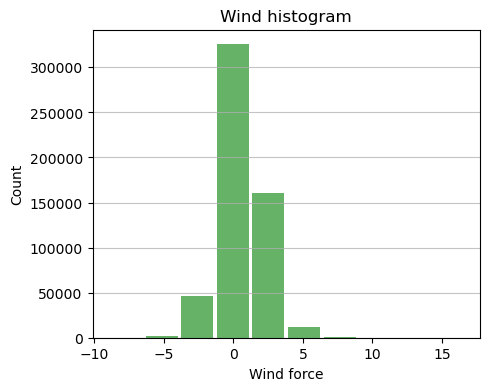

In [282]:
plt.figure(figsize=(5,4))
plt.hist(df_all3['wind'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Wind force")
plt.ylabel('Count')
plt.title('Wind histogram')

In [283]:
#looking for outliers
len(df_all3[df_all3['wind'] > 8])

93

In [284]:
len(df_all3[df_all3['wind'] < -7])

43

In [285]:
#all values above 8 change to 8, and below -7 change to -7
df_all3['wind'] = df_all3.apply(lambda row: -7 if row['wind'] < -7 else row['wind'], axis=1)
df_all3['wind'] = df_all3.apply(lambda row: 8 if row['wind'] > 8 else row['wind'], axis=1)

Text(0.5, 1.0, 'Wind histogram')

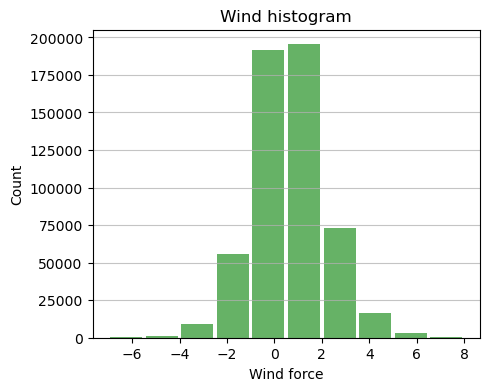

In [286]:
#histogram with corrected data - outliers removed
plt.figure(figsize=(5,4))
plt.hist(df_all3['wind'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Wind force')
plt.ylabel('Count')
plt.title('Wind histogram')

In [287]:
df_all3.describe()

,number,result,wind,age,if_country,year,month,start_career,start_season,pb,sb,height,Temperature,Humidity,Pressure,value
count,5.812770e+05,581277.000000,546387.000000,495752.000000,581277.000000,581270.000000,581270.000000,581277.000000,581277.000000,531202.000000,421584.000000,580198.000000,580823.000000,244443.000000,580823.000000,581277.000000
mean,1.450211e+07,10.818872,0.614906,22.326840,0.818414,2013.326432,5.756447,25.753974,4.553595,10.635686,10.718860,540.286740,20.050928,62.026837,1003.535579,0.999959
std,2.513533e+05,0.416071,1.523766,4.265129,0.385504,7.481361,1.956026,33.039361,3.870500,0.343726,0.333779,338.235359,5.947073,17.649942,28.295766,0.008085
min,1.416460e+07,9.580000,-7.000000,7.070000,0.000000,1955.000000,1.000000,1.000000,1.000000,9.580000,9.580000,1.000000,-19.800000,5.000000,625.000000,-1.000000
25%,1.423859e+07,10.600000,-0.300000,19.170000,1.000000,2010.000000,4.000000,6.000000,2.000000,10.390000,10.490000,320.000000,16.100000,50.000000,1002.555569,1.000000
50%,1.447617e+07,10.830000,0.600000,21.620000,1.000000,2015.000000,6.000000,14.000000,3.000000,10.660000,10.740000,460.000000,20.000000,63.000000,1011.980000,1.000000
75%,1.470666e+07,11.020000,1.500000,24.760000,1.000000,2019.000000,7.000000,32.000000,6.000000,10.890000,10.950000,760.000000,24.200000,75.000000,1016.673213,1.000000
max,1.505413e+07,73.960000,8.000000,57.710000,1.000000,2022.000000,12.000000,384.000000,43.000000,23.530000,47.530000,3265.000000,42.200000,100.000000,1043.000000,1.000000


#### competition country analysis

In [288]:
df_comp_country = df_all3[['country_competition', 'name']].groupby(by = 'country_competition', as_index = False).count()
df_comp_country = df_comp_country.rename(columns = {'name': 'count'})
df_comp_country = df_comp_country.sort_values('count', ascending = False).reset_index().drop(columns = 'index')
df_comp_country

,country_competition,count
0,United States,156650
1,Japan,38226
2,Germany,31633
3,France,29518
4,Great Britain & N.I.,29341
...,...,...
175,Aruba,1
176,Norfolk Island,1
177,Guam,1
178,Gabon,1


Text(0, 0.5, 'Number of countries')

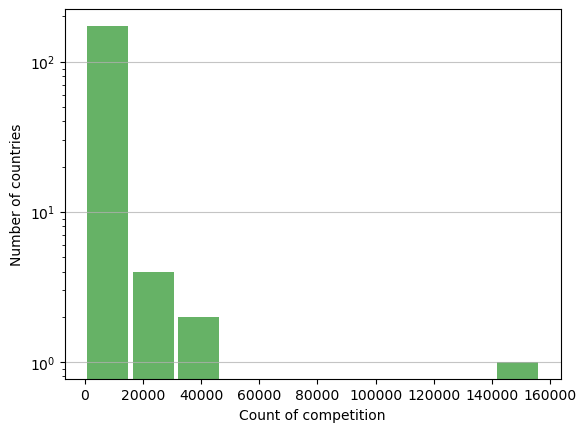

In [289]:
df_comp_country['count'].plot(kind = 'hist', logy = True, color = 'green', alpha = 0.6, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Count of competition')
plt.ylabel('Number of countries')

#### date competition analysis

In [290]:
df_all3['month'].min()

1.0

In [291]:
df_all3['month'].max()

12.0

Text(0.5, 1.0, 'Month')

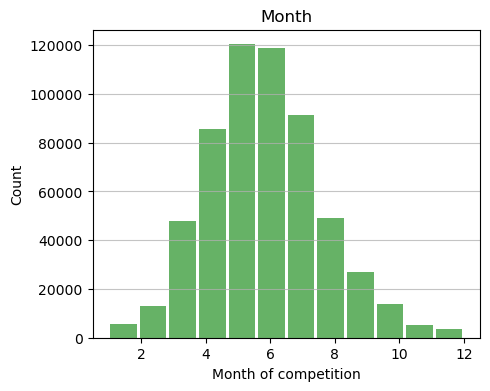

In [292]:
plt.figure(figsize=(5,4))
plt.hist(df_all3['month'], alpha = 0.6, rwidth=0.9, color = 'green', bins = 12)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Month of competition')
plt.ylabel('Count')
plt.title('Month')

In [293]:
df_comp_month = df_all3[['month', 'name']].groupby(by = 'month', as_index = False).count()
df_comp_month = df_comp_month.rename(columns = {'name': 'count'})
df_comp_month = df_comp_month.sort_values('count', ascending = False).reset_index().drop(columns = 'index')
df_comp_month

,month,count
0,5.0,120315
1,6.0,118803
2,7.0,91346
3,4.0,85509
4,8.0,48939
5,3.0,47848
6,9.0,27070
7,10.0,13895
8,2.0,13072
9,1.0,5655


In [294]:
df_all3['year'].min()

1955.0

In [295]:
df_all3['year'].max()

2022.0

In [296]:
df_year = df_all3[['year', 'number']].groupby(by = 'year', as_index = False).count()
df_year = df_year.rename(columns = {'number': 'count'})
df_year = df_year.sort_values('year', ascending = False).reset_index().drop(columns = 'index')
df_year

,year,count
0,2022.0,47890
1,2021.0,45432
2,2020.0,21577
3,2019.0,43331
4,2018.0,36264
...,...,...
61,1960.0,40
62,1959.0,2
63,1958.0,11
64,1956.0,2


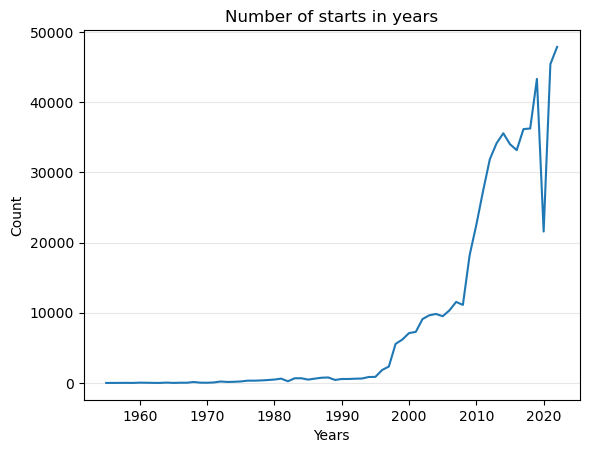

In [297]:
plt.plot(df_year['year'], df_year['count'])
plt.grid(axis='y', alpha=0.3)
plt.xlabel("Years")
plt.ylabel("Count")
plt.title("Number of starts in years")
plt.show()

In [298]:
dozen3 = [int(repr(x).split('.')[0][-2]) if np.isnan(x) == False else np.nan for x in df_all3['year']]
dozen4 = [(x * 10) + 2000 if x < 3 else (x*10)+1900 for x in dozen3]

In [299]:
pd.Series(dozen4).value_counts()

2010.0    334481
2020.0    114899
2000.0    103650
1990.0     19979
1980.0      5695
1970.0      2220
1960.0       330
1950.0        16
dtype: int64

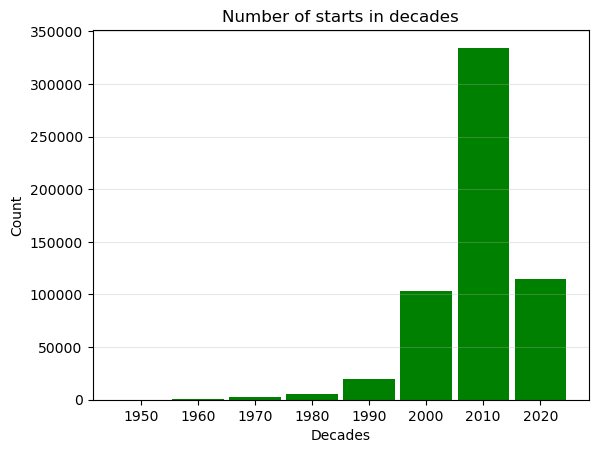

In [300]:
data = dict(pd.Series(dozen4).value_counts())
plt.bar(list(data.keys()), list(data.values()), color ='green', width = 9)

plt.grid(axis='y', alpha=0.3)
plt.xlabel("Decades")
plt.ylabel("Count")
plt.title("Number of starts in decades")
plt.show()

#### number of starts athlete in career

In [301]:
df_number = df_all3[['number', 'name']].groupby(by = 'number', as_index = False).count()
df_number = df_number.rename(columns = {'name': 'count'})
df_number = df_number.sort_values('count', ascending = False).reset_index().drop(columns = 'index')
df_number

,number,count
0,14249856,384
1,14192940,379
2,14224942,358
3,14218403,318
4,14202005,300
...,...,...
33723,14755804,1
33724,14497650,1
33725,14246600,1
33726,14755440,1


In [302]:
s.mean(df_number['count'])

17.234256404174573

In [303]:
s.median(df_number['count'])

9.0

Text(0.5, 1.0, 'Number of starts per athlete in career')

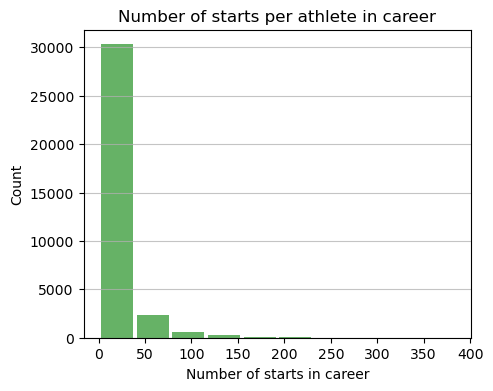

In [304]:
plt.figure(figsize=(5,4))
plt.hist(df_number['count'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of starts in career')
plt.ylabel('Count') 
plt.title('Number of starts per athlete in career')

In [305]:
len(df_number[df_number['count'] >= 10])

16746

In [306]:
16746/33728 

0.49650142314990514

#### number of starts athlete in season

In [307]:
df_number_season = df_all3[['number', 'year', 'name']].groupby(by = ['number', 'year'], as_index = False).count()
df_number_season = df_number_season.rename(columns = {'name': 'count'})
df_number_season = df_number_season.sort_values('count', ascending = False).reset_index().drop(columns = 'index')
df_number_season

,number,year,count
0,14194924,2003.0,43
1,14366936,2011.0,42
2,14194924,1998.0,39
3,14214947,2002.0,39
4,14170229,2005.0,36
...,...,...,...
125551,14419203,2014.0,1
125552,14419203,2016.0,1
125553,14782330,2017.0,1
125554,14419214,2010.0,1


In [308]:
s.mean(df_number_season['count'])

4.629567682946255

In [309]:
s.median(df_number_season['count'])

3.0

Text(0.5, 1.0, 'Number of starts per athlete in season')

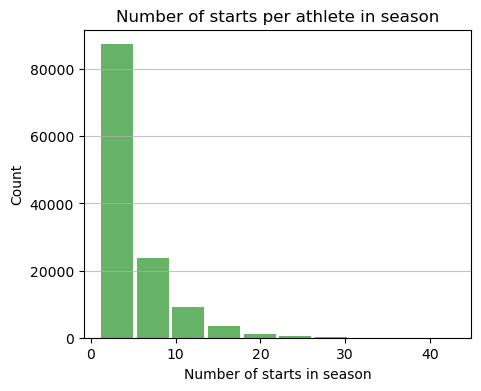

In [310]:
plt.figure(figsize=(5,4))
plt.hist(df_number_season['count'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of starts in season')
plt.ylabel('Count') 
plt.title('Number of starts per athlete in season')

In [315]:
len(df_number[df_number_season['count'] >= 10])

14312

In [316]:
#number of season starts
df_count_season = df_all3[['number', 'year']].drop_duplicates()
df_count_season = df_count_season[['number', 'year']].groupby(by = ['number'], as_index = False).count()
df_count_season = df_count_season.rename(columns = {'year': 'count_season'})
df_count_season = df_count_season.sort_values('count_season', ascending = False).reset_index().drop(columns = 'index')
df_count_season

,number,count_season
0,14218403,27
1,14192940,27
2,14192219,25
3,14199554,24
4,14224942,24
...,...,...
33723,14878228,1
33724,14637958,1
33725,15054126,1
33726,14344410,0


In [317]:
df_count_season['count_season'].mean()

3.7226043643263758

In [318]:
#average number of season starts
s.mean(df_number['count'])/s.mean(df_number_season['count'])

3.722649194148232

In [319]:
df_count_season['count_season'].median()

3.0

In [320]:
#median number of season starts
s.median(df_number['count'])/s.median(df_number_season['count'])

3.0

#### if_country analysis

In [321]:
#in as many as 82% of starts, the competitor ran in his country
round((df_all3['if_country'].value_counts())/len(df_all3), 2)

1    0.82
0    0.18
Name: if_country, dtype: float64

In [323]:
df_if_country = df_all3[['country', 'abb_coun', 'if_country']].groupby(by = ['country'], as_index = False).aggregate({'abb_coun': 'count', 'if_country': 'sum'})
df_if_country = df_if_country.rename(columns = {'abb_coun': 'count_starts', 'if_country': 'starts_in_country'})
df_if_country['start_rate'] = round(df_if_country['starts_in_country']/ df_if_country['count_starts'], 2)
df_if_country = df_if_country.sort_values('count_starts', ascending = False).reset_index().drop(columns = 'index')

df_if_country[:10]

,country,count_starts,starts_in_country,start_rate
0,United States,141392,134524,0.95
1,Japan,38438,37233,0.97
2,Great Britain & N.I.,31122,25585,0.82
3,Germany,27053,25186,0.93
4,France,25105,22535,0.90
5,Italy,21321,19465,0.91
6,Australia,19572,18349,0.94
7,Jamaica,17254,9427,0.55
8,Canada,14033,10057,0.72
9,Brazil,13702,11865,0.87


#### Temperature analysis

In [325]:
df_all3['Temperature'].min()

-19.8

In [326]:
df_all3['Temperature'].max()

42.2

Text(0.5, 1.0, 'Average temperature on the day of the competition')

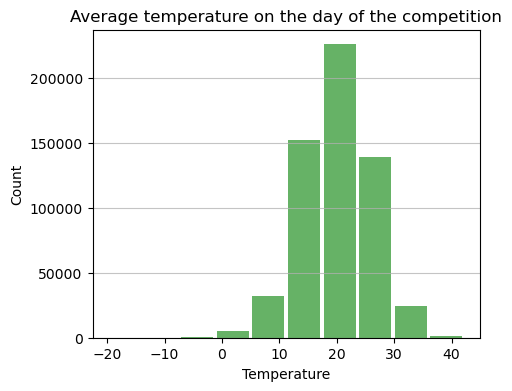

In [327]:
plt.figure(figsize=(5,4))
plt.hist(df_all3['Temperature'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.title('Average temperature on the day of the competition')

In [328]:
len(df_all3[df_all3['Temperature'] < -7])

71

In [329]:
len(df_all3[df_all3['Temperature'] > 39])

79

In [330]:
df_all3['Temperature'] = df_all3.apply(lambda row: -7 if row['Temperature'] < -7 else row['Temperature'], axis=1)
df_all3['Temperature'] = df_all3.apply(lambda row: 8 if row['Temperature'] > 39 else row['Temperature'], axis=1)

Text(0.5, 1.0, 'Average temperature on the day of the competition')

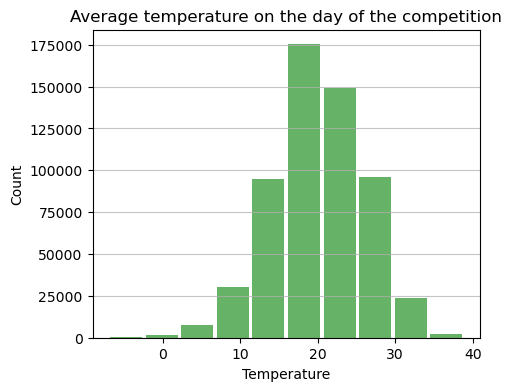

In [331]:
plt.figure(figsize=(5,4))
plt.hist(df_all3['Temperature'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.title('Average temperature on the day of the competition')

In [332]:
df_all3['Temperature'].mean()

20.047096018720413

In [333]:
df_all3['Pressure'].min()

625.0

In [334]:
df_all3['Pressure'].max()

1043.0

Text(0.5, 1.0, 'Average pressure on the day of the competition')

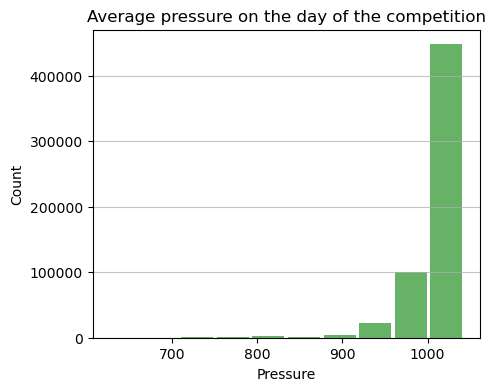

In [335]:
plt.figure(figsize=(5,4))
plt.hist(df_all3['Pressure'], alpha = 0.6, rwidth=0.9, color = 'green')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Pressure')
plt.ylabel('Count') 
plt.title('Average pressure on the day of the competition')

# Conversion of categorical values into numbers

### country conversion

In [336]:
country_list = list(set(list(df_all3['country']) + list(df_all3['country_competition'])))

In [337]:
country_id = [country_list.index(x) for x in df_all3['country']]
country_comp_id = [country_list.index(x) for x in df_all3['country_competition']]

In [338]:
df_all3['country_id'] = country_id
df_all3['country_comp_id'] = country_comp_id
df_all3

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,pb,sb,height,Temperature,Humidity,Pressure,Condition,value,country_id,country_comp_id
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,...,NaN,NaN,473.0,35.000000,26.5,1000.810000,Fair,1,192,10
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,...,11.40,NaN,61.0,17.141071,NaN,1008.029107,NaN,1,192,192
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,...,11.40,NaN,61.0,22.800000,69.0,1011.980000,Fair,1,192,192
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,...,11.40,NaN,61.0,22.800000,69.0,1011.980000,Fair,1,192,192
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,...,11.21,NaN,164.0,18.555556,NaN,1005.761693,NaN,1,192,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,...,NaN,NaN,438.0,11.400000,NaN,1018.700000,NaN,1,76,76
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,...,NaN,NaN,438.0,17.800000,83.0,1021.130000,Light Rain,1,76,76
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,...,10.71,10.71,438.0,17.800000,83.0,1021.130000,Light Rain,1,76,76
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,...,NaN,NaN,438.0,21.100000,80.5,1015.880000,Mostly Cloudy,1,76,76


### city conversion

In [340]:
#some cities exist in several countries
city_list = list(set(df_all3['city_competition'] + ' ' + df_all3['country_competition']))

In [341]:
city_id = [city_list.index(x) for x in df_all3['city_competition'] + ' ' + df_all3['country_competition']]

In [342]:
df_all3['city_comp_id'] = city_id
df_all3

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,sb,height,Temperature,Humidity,Pressure,Condition,value,country_id,country_comp_id,city_comp_id
0,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.40,2009-07-23,srb,Novi Sad,...,NaN,473.0,35.000000,26.5,1000.810000,Fair,1,192,10,2254
1,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.09,2010-07-09,est,Kose,...,NaN,61.0,17.141071,NaN,1008.029107,NaN,1,192,192,4136
2,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.23,2010-07-16,est,Tallinn,...,NaN,61.0,22.800000,69.0,1011.980000,Fair,1,192,192,3390
3,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,11.21,2010-07-16,est,Tallinn,...,NaN,61.0,22.800000,69.0,1011.980000,Fair,1,192,192,3390
4,Kaarel JÕEVÄLI,Estonia,est,14164603,1990-01-08,https://www.worldathletics.org/athletes/Estoni...,10.93,2011-06-04,fin,Seinäjoki,...,NaN,164.0,18.555556,NaN,1005.761693,NaN,1,192,93,243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,Kotaro YAMAMOTO,Japan,jpn,15054047,2005-10-04,https://www.worldathletics.org/athletes/Japan/...,10.88,2022-11-03,jpn,Omuta,...,NaN,438.0,11.400000,NaN,1018.700000,NaN,1,76,76,2113
581273,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.71,2022-10-09,jpn,Yokohama,...,NaN,438.0,17.800000,83.0,1021.130000,Light Rain,1,76,76,1826
581274,Kazuya IWATA,Japan,jpn,15054107,2005-06-25,https://www.worldathletics.org/athletes/Japan/...,10.79,2022-10-09,jpn,Yokohama,...,10.71,438.0,17.800000,83.0,1021.130000,Light Rain,1,76,76,1826
581275,Subiarann MUGABI,Japan,jpn,15054126,2004-03-01,https://www.worldathletics.org/athletes/Japan/...,10.96,2022-10-15,jpn,Kanazawa,...,NaN,438.0,21.100000,80.5,1015.880000,Mostly Cloudy,1,76,76,3041


In [343]:
df_all3.to_csv(path + '\df_good_age_wind.csv')

## Data gaps

<Axes: >

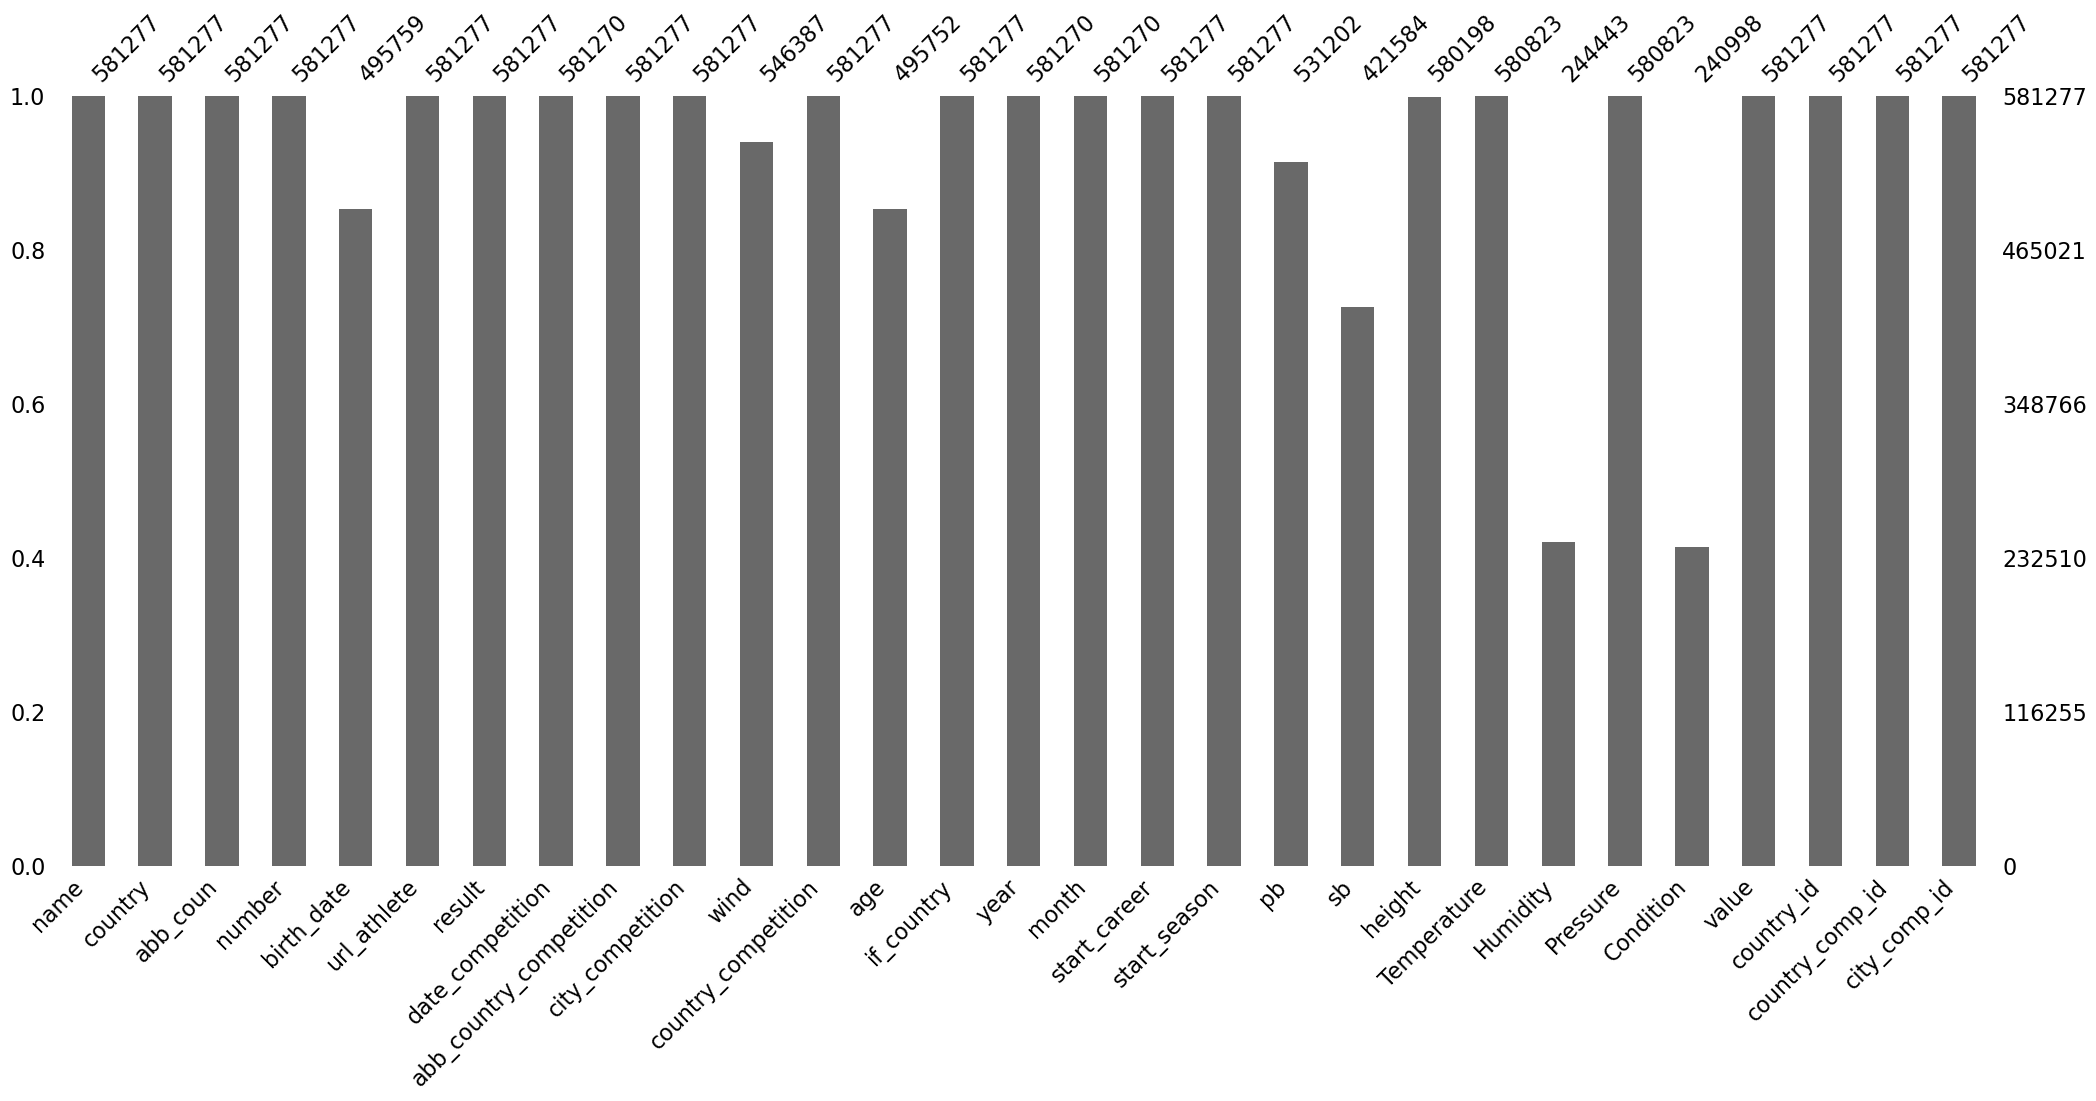

In [344]:
msno.bar(df_all3)

<Axes: >

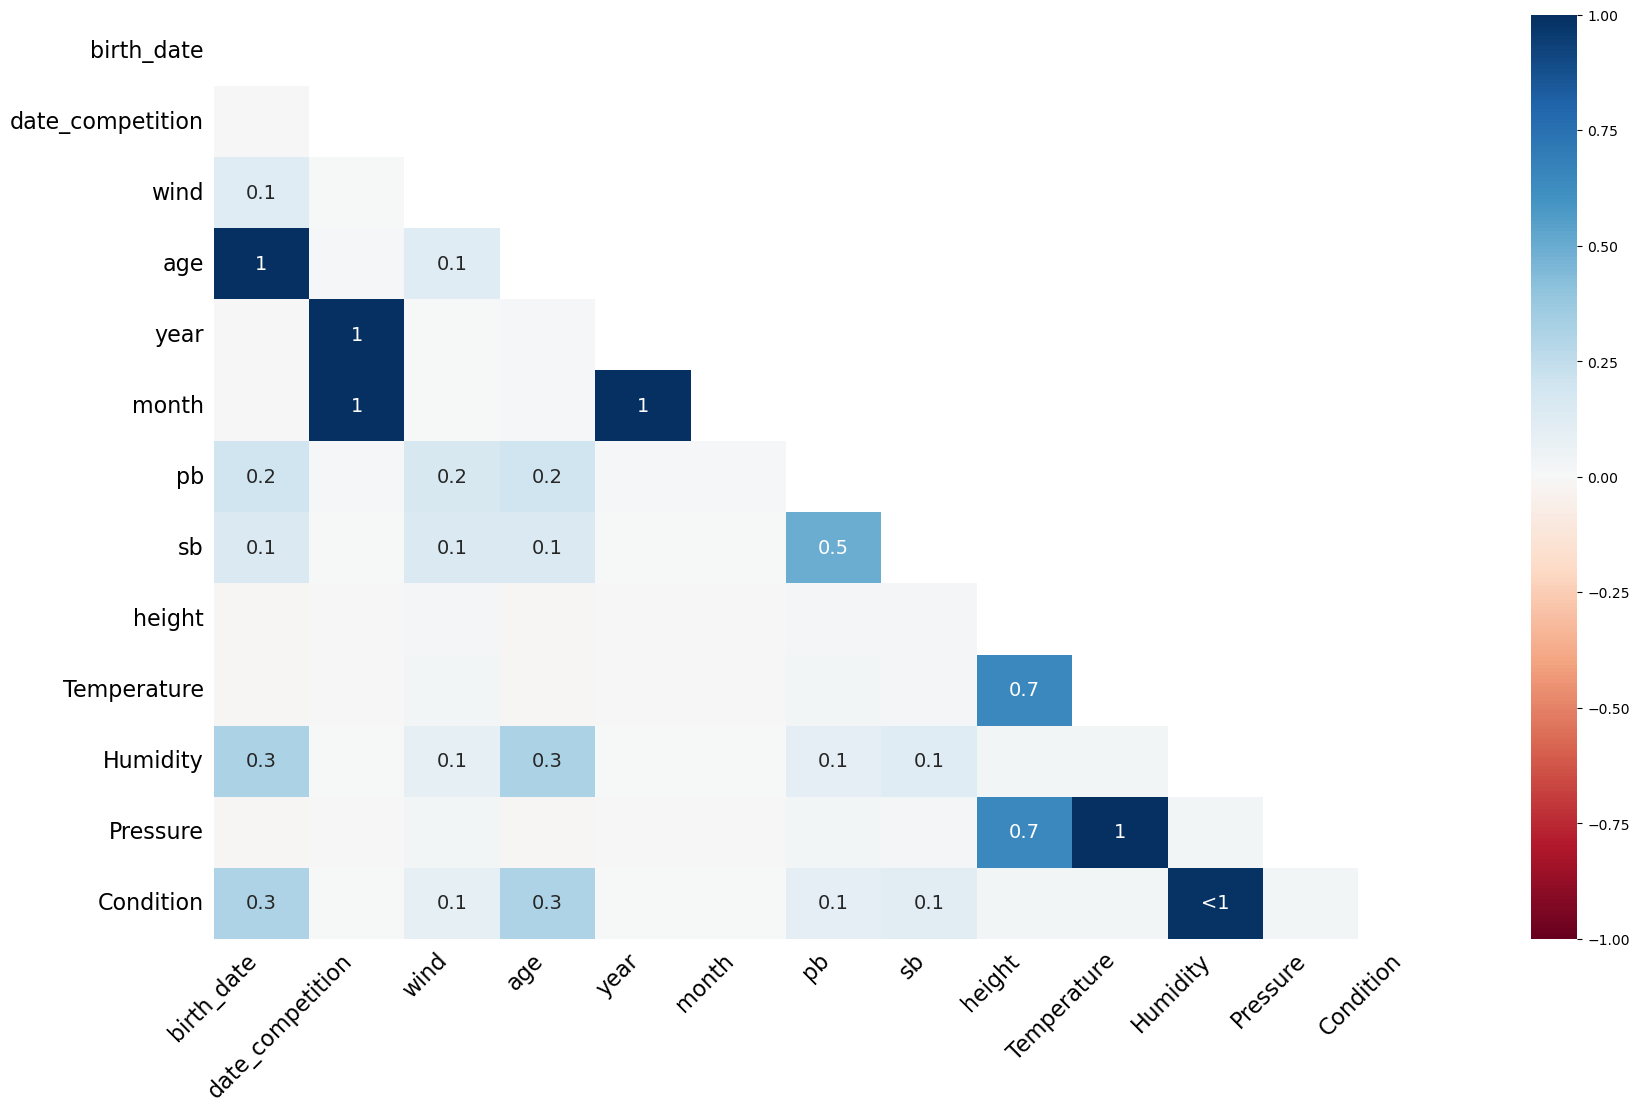

In [345]:
msno.heatmap(df_all3)

## Filling empty values

In [346]:
df_all3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581277 entries, 0 to 581276
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   name                     581277 non-null  object        
 1   country                  581277 non-null  object        
 2   abb_coun                 581277 non-null  object        
 3   number                   581277 non-null  int64         
 4   birth_date               495759 non-null  datetime64[ns]
 5   url_athlete              581277 non-null  object        
 6   result                   581277 non-null  float64       
 7   date_competition         581270 non-null  datetime64[ns]
 8   abb_country_competition  581277 non-null  object        
 9   city_competition         581277 non-null  object        
 10  wind                     546387 non-null  float64       
 11  country_competition      581277 non-null  object        
 12  age             

### Filling empty values for wind

In [347]:
#finding the column with the highest correlation to the wind column, disregarding itself and the result
c = [0]
#d = 0
ind = []
for i, cor in enumerate(df_all3.corr()['wind']):
    col_name = list(df_all3.corr().columns)[i]
    if col_name != 'wind' and col_name != 'result':
        if abs(cor) > c[-1]:
            c.append(abs(cor))
            ind.append(i)
c[-2:], df_all3.corr().columns[ind[-2:]]
#wind has the greatest correlation with temperature and month

([0.0773704658142473, 0.08451557638948122],
 Index(['month', 'Temperature'], dtype='object'))

In [348]:
#grouped by months, because there is a limited number of them, and not as for temperature
df_wind = df_all3[['month', 'wind']].groupby(by = ['month'], as_index= False).median()
df_wind = df_wind.rename(columns={'wind':'meanWind'})
df_wind

,month,meanWind
0,1.0,0.6
1,2.0,0.5
2,3.0,0.7
3,4.0,0.9
4,5.0,0.7
5,6.0,0.5
6,7.0,0.4
7,8.0,0.3
8,9.0,0.3
9,10.0,0.5


In [349]:
df_all4 = pd.merge(df_all3, df_wind, how = 'left', on = ['month'])
df_all4['wind'] = df_all4.apply(lambda row: row['meanWind'] if m.isnan(row['wind']) else row['wind'], axis=1)
df_all4 = df_all4.drop(columns = 'meanWind')

In [350]:
df_all4[df_all4['wind'].isna()]

,name,country,abb_coun,number,birth_date,url_athlete,result,date_competition,abb_country_competition,city_competition,...,sb,height,Temperature,Humidity,Pressure,Condition,value,country_id,country_comp_id,city_comp_id
160839,James SCOTT,United States,usa,14250820,1980-09-16,https://www.worldathletics.org/athletes/United...,10.47,NaT,usa,MO,...,NaN,760.0,17.880388,NaN,1018.22296,NaN,-1,133,133,2973
180546,Joe FRANKLIN,United States,usa,14344410,1978-07-11,https://www.worldathletics.org/athletes/United...,10.00,NaT,usa,LA,...,NaN,760.0,17.880388,NaN,1018.22296,NaN,-1,133,133,23


### Filling empty values for pb and sb

In [351]:
#after completing the empty values in the wind column, you can partially fill in the gaps in the sb and pb columns
pb_record = actual_record(df_all4['start_career'], df_all4['wind'], df_all4['result'])
sb_record = actual_record(df_all4['start_season'], df_all4['wind'], df_all4['result'])

In [352]:
df_all4['pb'] = pb_record
df_all4['sb'] = sb_record

In [353]:
len(df_all4[df_all4['pb'].isna()])

40373

In [354]:
len(df_all4[df_all4['sb'].isna()])

145085

In [355]:
len(df_all4['number'].unique())

33728

In [356]:
def new_sb(col_career, col_season, col_wind, col_result):
    res = {}
    for i in range(len(col_career)):
        if col_season[i] == 1:
            s = 0
            
        if col_career[i] == 1:  #first career start always nan
            res[i] = m.nan

        elif col_career[i] != 1 and col_season[i] == 1:  #first start of the season, but not in the career
            if col_wind[i-1] <= 2:
                res[i] = col_result[i-1]   #if the wind is allowed, we take the obtained result
            else:
                res[i] = res[i-1]   #in other cases, we take the last result from the previous season or its sb

        else:   #next season starts
            if col_wind[i-1] <= 2 and s == 0:  #we are looking for the first start in the new season with acceptable wind
                res[i] = col_result[i-1]
                s = s+1
            elif col_wind[i-1] <= 2 and col_result[i-1] < res[i-1]: 
                res[i] = col_result[i-1]      #if the wind is allowed we take this result
            else:
                res[i] = res[i-1]    #in other cases, we take the previous sb
    return(res)

In [357]:
res_sb = new_sb(df_all4['start_career'], df_all4['start_season'], df_all4['wind'], df_all4['result'])

In [358]:
df_all4['sb'] = res_sb

In [359]:
len(df_all4[df_all4['sb'].isna()])

40373

# Selection of columns needed for training

In [360]:
df_all4.columns

Index(['name', 'country', 'abb_coun', 'number', 'birth_date', 'url_athlete',
       'result', 'date_competition', 'abb_country_competition',
       'city_competition', 'wind', 'country_competition', 'age', 'if_country',
       'year', 'month', 'start_career', 'start_season', 'pb', 'sb', 'height',
       'Temperature', 'Humidity', 'Pressure', 'Condition', 'value',
       'country_id', 'country_comp_id', 'city_comp_id'],
      dtype='object')

In [361]:
df_learn = df_all4[['number', 'age', 'wind', 'year', 'month', 'start_career', 'start_season', 'pb', 'sb', 'height', 'country_id', 'country_comp_id', 'if_country', 'city_comp_id', 'Temperature', 'Pressure', 'result']]
df_learn

,number,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result
0,14164603,19.55,-2.3,2009.0,7.0,1,1,NaN,NaN,473.0,192,10,0,2254,35.000000,1000.810000,11.40
1,14164603,20.51,2.1,2010.0,7.0,2,1,11.40,11.40,61.0,192,192,1,4136,17.141071,1008.029107,11.09
2,14164603,20.53,2.4,2010.0,7.0,3,2,11.40,11.40,61.0,192,192,1,3390,22.800000,1011.980000,11.23
3,14164603,20.53,-0.7,2010.0,7.0,4,3,11.40,11.40,61.0,192,192,1,3390,22.800000,1011.980000,11.21
4,14164603,21.42,2.8,2011.0,6.0,5,1,11.21,11.21,164.0,192,93,0,243,18.555556,1005.761693,10.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,15054047,17.09,1.5,2022.0,11.0,1,1,NaN,NaN,438.0,76,76,1,2113,11.400000,1018.700000,10.88
581273,15054107,17.30,1.8,2022.0,10.0,1,1,NaN,NaN,438.0,76,76,1,1826,17.800000,1021.130000,10.71
581274,15054107,17.30,1.1,2022.0,10.0,2,2,10.71,10.71,438.0,76,76,1,1826,17.800000,1021.130000,10.79
581275,15054126,18.64,0.4,2022.0,10.0,1,1,NaN,NaN,438.0,76,76,1,3041,21.100000,1015.880000,10.96


In [362]:
#df with date column will be needed for lstm model
df_learn_lstm = df_all4[['number', 'date_competition', 'age', 'wind', 'year', 'month', 'start_career', 'start_season', 'pb', 'sb', 'height', 'country_id', 'country_comp_id', 'if_country', 'city_comp_id', 'Temperature', 'Pressure', 'result']]

In [363]:
df_learn.to_csv(path + '\df_learn.csv')
df_learn_lstm.to_csv(path + '\df_learn_lstm.csv')

# Normalization of features

In [364]:
def norm_features(df, col):
    c_max = df[col].max()
    c_min = df[col].min()
    
    if df[col].min() == 0:
        df[col] = df.apply(lambda row: row[col]/c_max, axis=1)
        
    elif df[col].min() != 0 and col != 'wind':
        df[col] = df.apply(lambda row: (row[col]-c_min)/(c_max - c_min), axis=1)
    
    else:
        c_min_pos = df[col][df[col] > 0].min()
        c_max_neg = df[col][df[col] < 0].max()

        df[col] = df.apply(lambda row: (row[col])/(2*(c_max + c_min_pos)) + 0.5 if row[col] > 0 else(0.5 if row[col] == 0 else (row[col]+abs(c_min))/(2*abs(c_min)) ), axis=1)

In [365]:
df_index = df_learn[['number']].groupby(by = ['number'], as_index='False').min()
df_index = df_index.reset_index()
df_index['index'] = df_index.index

In [366]:
#In order to minimize the inequality in the size of identifiers, 
#for which the difference between the largest and the smallest value was almost 900 000, 
#the number column was removed and an index was added, the values of which correspond to subsequent players.
df_learn = df_learn.merge(df_index, how='left', on=['number'])
df_learn = df_learn.drop(columns = 'number')
df_learn

,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result,index
0,19.55,-2.3,2009.0,7.0,1,1,NaN,NaN,473.0,192,10,0,2254,35.000000,1000.810000,11.40,0
1,20.51,2.1,2010.0,7.0,2,1,11.40,11.40,61.0,192,192,1,4136,17.141071,1008.029107,11.09,0
2,20.53,2.4,2010.0,7.0,3,2,11.40,11.40,61.0,192,192,1,3390,22.800000,1011.980000,11.23,0
3,20.53,-0.7,2010.0,7.0,4,3,11.40,11.40,61.0,192,192,1,3390,22.800000,1011.980000,11.21,0
4,21.42,2.8,2011.0,6.0,5,1,11.21,11.21,164.0,192,93,0,243,18.555556,1005.761693,10.93,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581272,17.09,1.5,2022.0,11.0,1,1,NaN,NaN,438.0,76,76,1,2113,11.400000,1018.700000,10.88,33725
581273,17.30,1.8,2022.0,10.0,1,1,NaN,NaN,438.0,76,76,1,1826,17.800000,1021.130000,10.71,33726
581274,17.30,1.1,2022.0,10.0,2,2,10.71,10.71,438.0,76,76,1,1826,17.800000,1021.130000,10.79,33726
581275,18.64,0.4,2022.0,10.0,1,1,NaN,NaN,438.0,76,76,1,3041,21.100000,1015.880000,10.96,33727


In [367]:
#there is no date, and we normalize the index together with the rest
for col in df_learn.columns:
    if col != 'result':
        norm_features(df_learn, col)

In [368]:
#not normalize the number column so that we can train the lstm model for given players
#not normalize the data column because it has no numeric type
for col in df_learn_lstm.columns:
    if col != 'result' and col != 'number' and col != 'date_competition':
        norm_features(df_learn_lstm, col)

In [369]:
df_learn.describe()

,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result,index
count,495752.000000,581275.000000,581270.000000,581270.000000,581277.000000,581277.000000,540904.000000,540904.000000,580198.000000,581277.000000,581277.000000,581277.000000,581277.000000,580823.000000,580823.000000,581277.000000,581277.000000
mean,0.301280,0.535133,0.870544,0.432404,0.064632,0.084609,0.075356,0.018206,0.165223,0.491602,0.509892,0.818414,0.472559,0.589261,0.905588,10.818872,0.389800
std,0.084225,0.096083,0.111662,0.177821,0.086265,0.092155,0.024575,0.005973,0.103626,0.238506,0.230119,0.385504,0.290502,0.129427,0.067693,0.416071,0.283003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.580000,0.000000
25%,0.238942,0.485714,0.820896,0.272727,0.013055,0.023810,0.058065,0.014601,0.097733,0.352381,0.363636,1.000000,0.207148,0.503268,0.903243,10.600000,0.114004
50%,0.287322,0.537037,0.895522,0.454545,0.033943,0.047619,0.077419,0.018484,0.140625,0.571429,0.607656,1.000000,0.474724,0.588235,0.925789,10.830000,0.357725
75%,0.349329,0.592593,0.955224,0.545455,0.080940,0.119048,0.093190,0.021746,0.232537,0.633333,0.636364,1.000000,0.710322,0.679739,0.937017,11.020000,0.620868
max,1.000000,0.993827,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,73.960000,1.000000


In [370]:
df_learn.to_csv(path + '\df_normalization.csv')
df_learn_lstm.to_csv(path + '\df_normalization_lstm.csv')

### Correlation

In [371]:
df_learn.corr()

,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result,index
age,1.000000,0.004218,-0.133061,0.011593,0.587747,0.114697,-0.485122,-0.244349,0.005441,0.006694,0.042283,-0.198220,0.006565,0.013247,-0.027990,-0.209203,-0.454728
wind,0.004218,1.000000,0.004830,-0.077944,-0.042432,-0.058080,0.023694,0.020201,0.035689,0.037778,0.049497,0.022195,-0.019934,-0.083385,0.045525,-0.108467,0.011470
year,-0.133061,0.004830,1.000000,-0.054470,-0.007157,-0.050304,0.351046,0.299551,0.001660,-0.036866,-0.049627,0.231339,0.007586,-0.003515,0.009177,0.251264,0.709626
month,0.011593,-0.077944,-0.054470,1.000000,0.116811,0.426503,-0.047157,-0.104800,-0.178535,-0.078572,-0.101119,-0.091975,0.034107,0.162628,-0.049188,-0.009513,-0.003319
start_career,0.587747,-0.042432,-0.007157,0.116811,1.000000,0.405788,-0.571043,-0.367909,-0.089147,-0.084282,-0.043185,-0.229148,0.005239,0.069077,-0.065621,-0.270731,-0.347942
start_season,0.114697,-0.058080,-0.050304,0.426503,0.405788,1.000000,-0.315094,-0.378033,-0.098430,-0.073678,-0.062727,-0.166643,-0.006371,0.128970,-0.052235,-0.197216,-0.125551
pb,-0.485122,0.023694,0.351046,-0.047157,-0.571043,-0.315094,1.000000,0.753210,-0.022163,0.015096,-0.038896,0.333992,0.001702,-0.133913,0.063779,0.550084,0.471458
sb,-0.244349,0.020201,0.299551,-0.104800,-0.367909,-0.378033,0.753210,1.000000,-0.024790,0.009387,-0.028996,0.271242,0.006487,-0.131786,0.043352,0.488438,0.318151
height,0.005441,0.035689,0.001660,-0.178535,-0.089147,-0.098430,-0.022163,-0.024790,1.000000,0.263563,0.323113,-0.010177,-0.037217,-0.031606,-0.099831,-0.042429,0.021127
country_id,0.006694,0.037778,-0.036866,-0.078572,-0.084282,-0.073678,0.015096,0.009387,0.263563,1.000000,0.761353,0.130599,0.022567,-0.060453,-0.028532,-0.007368,-0.020964


Text(0.5, 1.0, 'Result')

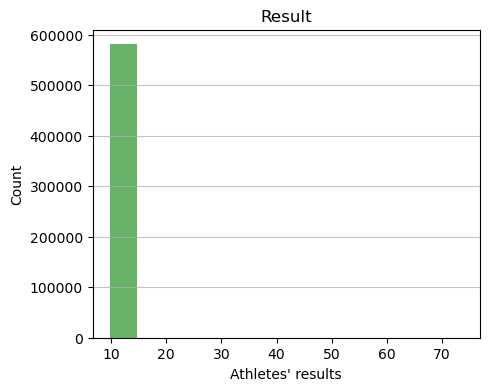

In [372]:
#outlier results histogram
plt.figure(figsize=(5,4))
plt.hist(df_learn['result'], alpha = 0.6, rwidth=0.9, color = 'green', bins = 12)
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Athletes' results")
plt.ylabel('Count')
plt.title('Result')

In [373]:
df_learn2 = df_learn[df_learn['result']<=12].reset_index().drop(columns = 'level_0')

Text(0.5, 1.0, 'Result')

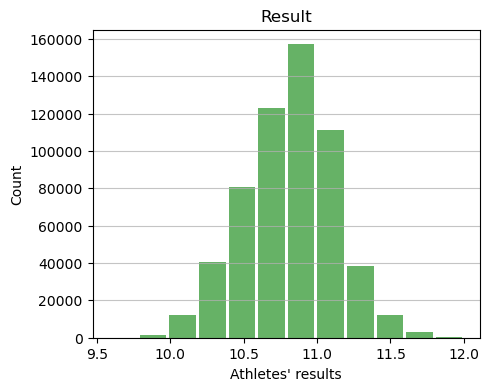

In [374]:
#histogram of results without outliers
plt.figure(figsize=(5,4))
plt.hist(df_learn2['result'], alpha = 0.6, rwidth=0.9, color = 'green', bins = 12)
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Athletes' results")
plt.ylabel('Count')
plt.title('Result')

In [375]:
df_learn2.corr()

,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result,index
age,1.000000,0.004038,-0.133110,0.011791,0.587706,0.114690,-0.485003,-0.245945,0.005270,0.006463,0.042036,-0.198169,0.006472,0.013238,-0.027984,-0.282382,-0.454703
wind,0.004038,1.000000,0.004905,-0.077927,-0.042583,-0.058237,0.024156,0.020692,0.035628,0.037611,0.049362,0.022287,-0.019924,-0.083503,0.045625,-0.142922,0.011548
year,-0.133110,0.004905,1.000000,-0.054495,-0.007067,-0.050284,0.351482,0.302011,0.001603,-0.036824,-0.049649,0.231339,0.007580,-0.003606,0.009088,0.334012,0.709625
month,0.011791,-0.077927,-0.054495,1.000000,0.116925,0.426618,-0.047459,-0.105933,-0.178676,-0.078632,-0.101234,-0.092026,0.034114,0.162738,-0.049165,-0.017296,-0.003443
start_career,0.587706,-0.042583,-0.007067,0.116925,1.000000,0.405814,-0.571214,-0.370564,-0.089279,-0.084370,-0.043304,-0.228999,0.005242,0.069060,-0.065600,-0.370008,-0.347882
start_season,0.114690,-0.058237,-0.050284,0.426618,0.405814,1.000000,-0.315187,-0.380754,-0.098561,-0.073826,-0.062893,-0.166580,-0.006416,0.129008,-0.052237,-0.268843,-0.125602
pb,-0.485003,0.024156,0.351482,-0.047459,-0.571214,-0.315187,1.000000,0.758616,-0.021811,0.015547,-0.038458,0.334071,0.001724,-0.134094,0.063806,0.757437,0.471855
sb,-0.245945,0.020692,0.302011,-0.105933,-0.370564,-0.380754,0.758616,1.000000,-0.024824,0.009724,-0.028928,0.273191,0.006444,-0.133147,0.043619,0.675963,0.320614
height,0.005270,0.035628,0.001603,-0.178676,-0.089279,-0.098561,-0.021811,-0.024824,1.000000,0.263143,0.322717,-0.010159,-0.037200,-0.031819,-0.099924,-0.057865,0.021115
country_id,0.006463,0.037611,-0.036824,-0.078632,-0.084370,-0.073826,0.015547,0.009724,0.263143,1.000000,0.761289,0.130679,0.022580,-0.060428,-0.028515,-0.009554,-0.020879


In [389]:
df_learn2 = df_learn2.reindex(columns=['index', 'age', 'wind', 'year', 'month', 'start_career', 'start_season', 'pb','sb', 'height', 'country_id', 'country_comp_id', 'if_country','city_comp_id', 'Temperature', 'Pressure', 'result'])

In [390]:
corr_list = list(df_learn2.corr()['result'])[:-1]

<Axes: title={'center': 'Feature coefficients with correlation'}>

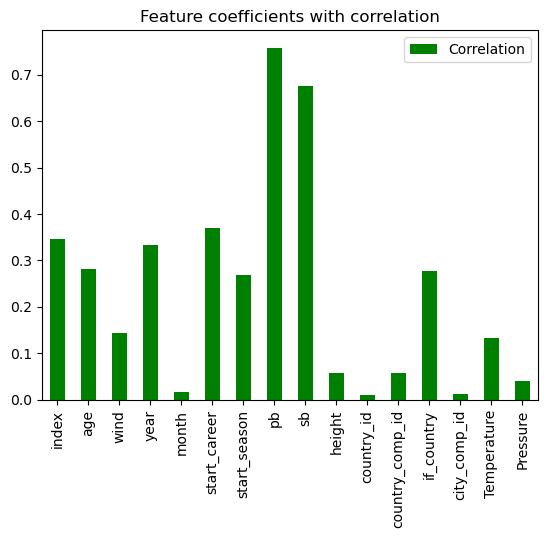

In [391]:
plotdata = pd.DataFrame({
    'Correlation': np.absolute(corr_list)},
index=df_learn2.columns[:-1])
plotdata.plot(kind= 'bar',  title = 'Feature coefficients with correlation', color = 'green')

<Axes: >

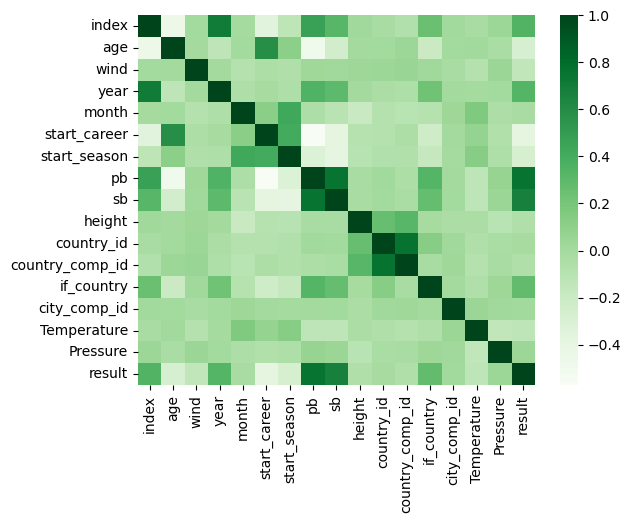

In [392]:
sns.heatmap(df_learn2.corr(), cmap = 'Greens')

In [393]:
df_learn2.to_csv(path + '\df_normalization_to12.csv')

## Lasso

In [394]:
#columns with empty values
col_nan = []
for col in df_learn2.columns:
    if len(df_learn2[df_learn2[col].isna()]) > 0:
        col_nan.append(col)
col_nan

['age',
 'wind',
 'year',
 'month',
 'pb',
 'sb',
 'height',
 'Temperature',
 'Pressure']

In [395]:
#deleting records with empty values
for c in col_nan:
    df_learn2 = df_learn2[df_learn2[c].isna() == False]
df_learn2 = df_learn2.reset_index().drop(columns = 'level_0')
df_learn2

,index,age,wind,year,month,start_career,start_season,pb,sb,height,country_id,country_comp_id,if_country,city_comp_id,Temperature,Pressure,result
0,0.000000,0.265403,0.629630,0.820896,0.545455,0.002611,0.000000,0.130466,0.028270,0.018382,0.914286,0.918660,1.0,0.972490,0.525949,0.916338,11.09
1,0.000000,0.265798,0.648148,0.820896,0.545455,0.005222,0.023810,0.130466,0.028270,0.018382,0.914286,0.918660,1.0,0.797084,0.649237,0.925789,11.23
2,0.000000,0.265798,0.450000,0.820896,0.545455,0.007833,0.047619,0.130466,0.028270,0.018382,0.914286,0.918660,1.0,0.797084,0.649237,0.925789,11.21
3,0.000000,0.283373,0.672840,0.835821,0.454545,0.010444,0.000000,0.116846,0.025318,0.049939,0.914286,0.444976,0.0,0.057136,0.556766,0.910913,10.93
4,0.000000,0.284755,0.574074,0.835821,0.545455,0.013055,0.023810,0.116846,0.025318,0.052696,0.914286,0.674641,0.0,0.387726,0.417574,0.900073,11.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466827,0.999852,0.231438,0.442857,1.000000,0.909091,0.005222,0.047619,0.093190,0.020193,0.189951,0.014286,0.014354,1.0,0.515166,0.762309,0.910646,10.96
466828,0.999881,0.209913,0.435714,1.000000,0.727273,0.002611,0.023810,0.091039,0.019727,0.133885,0.361905,0.363636,1.0,0.910416,0.315904,0.945215,10.87
466829,0.999881,0.209913,0.485714,1.000000,0.727273,0.005222,0.047619,0.091039,0.019727,0.133885,0.361905,0.363636,1.0,0.910416,0.315904,0.945215,10.82
466830,0.999970,0.202014,0.567901,1.000000,0.818182,0.002611,0.023810,0.081004,0.017552,0.133885,0.361905,0.363636,1.0,0.429344,0.540305,0.947679,10.79


In [396]:
#division into input and output features
col_num = df_learn2.shape[1]
df_X = df_learn2.values[:,0:col_num-1]
df_Y = df_learn2.values[:,col_num-1]

<Axes: title={'center': 'Feature coefficients depending on alpha'}>

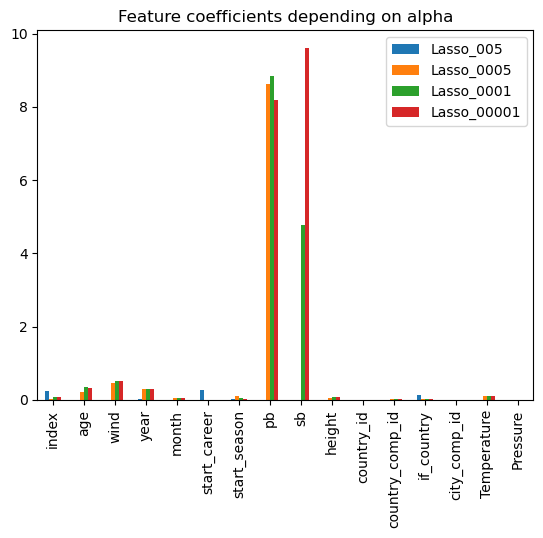

In [397]:
#lasso with different alpha coefficients
lasso_005 = Lasso(alpha = 0.005)
lasso_005.fit(df_X, df_Y)

lasso_0005 = Lasso(alpha = 0.0005)
lasso_0005.fit(df_X, df_Y)

lasso_0001 = Lasso(alpha = 0.0001)
lasso_0001.fit(df_X, df_Y)

lasso_00001 = Lasso(alpha = 0.00001)
lasso_00001.fit(df_X, df_Y)

plotdata = pd.DataFrame({
    'Lasso_005': np.absolute(lasso_005.coef_),
    'Lasso_0005': np.absolute(lasso_0005.coef_),
    'Lasso_0001': np.absolute(lasso_0001.coef_),
    'Lasso_00001': np.absolute(lasso_00001.coef_)},
index=df_learn2.columns[:col_num-1]
)
plotdata.plot(kind= 'bar', title = 'Feature coefficients depending on alpha')

In [398]:
#pb and sb interfere with the reading of the graph, removing them in order to better compare the other features
df_learn3 = df_learn2.drop(columns = ['pb', 'sb'])

col_num2 = df_learn3.shape[1]
df_X3 = df_learn3.values[:,0:col_num2-1]
df_Y3 = df_learn3.values[:,col_num2-1]

<Axes: title={'center': 'Feature coefficients depending on alpha withou pb and sb'}>

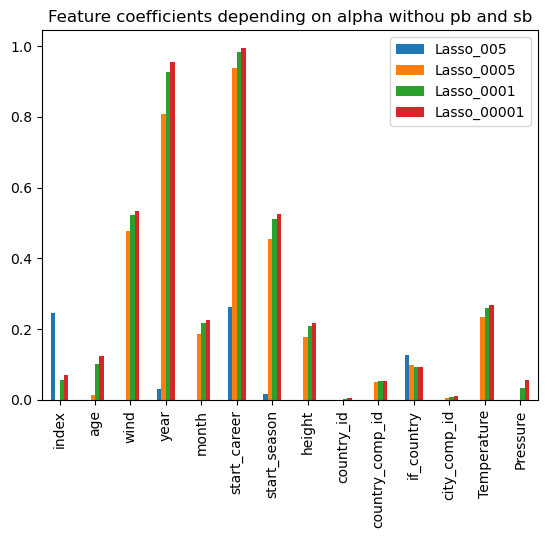

In [399]:
#new lasso with different alpha coefficients - without pb and sb
lasso_05 = Lasso(alpha = 0.005)
lasso_05.fit(df_X3, df_Y3)

lasso_005 = Lasso(alpha = 0.0005)
lasso_005.fit(df_X3, df_Y3)

lasso_01 = Lasso(alpha = 0.0001)
lasso_01.fit(df_X3, df_Y3)

lasso_001 = Lasso(alpha = 0.00001)
lasso_001.fit(df_X3, df_Y3)

plotdata = pd.DataFrame({
    'Lasso_005': np.absolute(lasso_05.coef_),
    'Lasso_0005': np.absolute(lasso_005.coef_),
    'Lasso_0001': np.absolute(lasso_01.coef_),
    'Lasso_00001': np.absolute(lasso_001.coef_)},
index=df_learn3.columns[:col_num2-1]
)
plotdata.plot(kind= 'bar',  title = 'Feature coefficients depending on alpha withou pb and sb')

### Mutual info

In [400]:
mutual = mutual_info_regression(df_X, df_Y)

In [401]:
mutual_new = mutual_info_regression(df_X3, df_Y3)

<Axes: title={'center': 'Feature coefficients with mutual information'}>

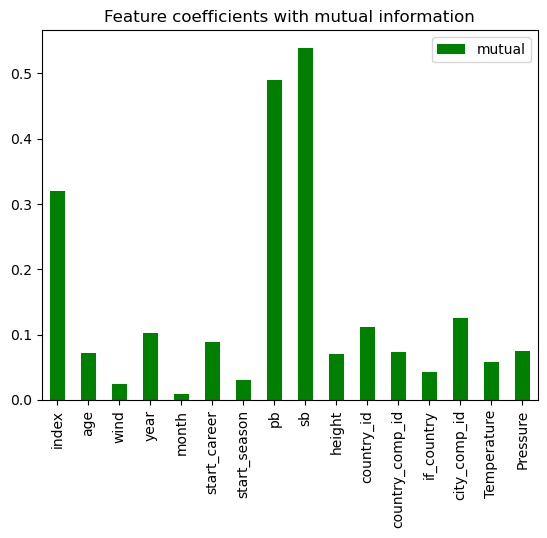

In [402]:
plotdata = pd.DataFrame({
    'mutual': mutual},
index=df_learn2.columns[:col_num-1])
plotdata.plot(kind= 'bar',  title = 'Feature coefficients with mutual information', color = 'green')

#### Compare Correlation vs Lasso vs Mutual information

In [403]:
#list of correlations of subsequent features to the output feature
corr_list_new = list(df_learn3.corr()['result'])[:-1]

<Axes: title={'center': 'Comparison between correlation vs Lasso vs mutual information'}>

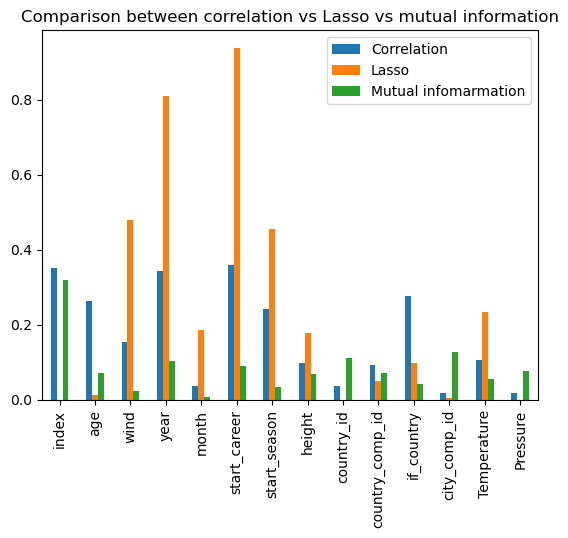

In [404]:
plotdata = pd.DataFrame({
    'Correlation': np.absolute(corr_list_new),
    'Lasso': np.absolute(lasso_005.coef_),
    'Mutual infomarmation': mutual_new},
index=df_learn3.columns[:col_num2-1]
)
plotdata.plot(kind= 'bar',  title = 'Comparison between correlation vs Lasso vs mutual information')

In [405]:
list(np.absolute(corr_list_new) + np.absolute(lasso_005.coef_) + mutual_new)

[0.6705526153076018,
 0.3504320597387189,
 0.6584566173797826,
 1.2552653506212337,
 0.23371982682673847,
 1.3854325320902396,
 0.7299603813539741,
 0.34604918340438323,
 0.14902029808484973,
 0.2145948745946772,
 0.4150787230325708,
 0.14988877212556026,
 0.39677226177072455,
 0.0949040564869223]